In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

seed = 42
# Read the data
langs = ["en", "cs", "de"]
steps_epoch_mapping = {
    5: 500,
    10: 1000,
    15: 1500,
    20: 2000,
    25: 2500,
    30: 3000,
    35: 3500,
    40: 4000,
}
epoch_steps_mapping = {v: k for k, v in steps_epoch_mapping.items()}
steps = steps_epoch_mapping.values()
kind = ["noisevignere3", "noiseconstenigma"]
evaldatasets = {lang: f"final_eval_dataset_{lang}.csv" for lang in langs}
vignere_losses = {lang: f"{lang}_vignere_loss.csv" for lang in langs}
enigmas = {lang: f"{lang}_enigma_loss.csv" for lang in langs}
eval_col = "eval_loss"


def vignerecol_name(lang, epoch):
    return f"{lang}_noisevignere3_{steps_epoch_mapping[epoch]}_cer"


def enigmacol_name(lang, epoch):
    return f"{lang}_noiseconstenigma_{steps_epoch_mapping[epoch]}_cer"


data_dfs: dict[str, pd.DataFrame] = {
    lang: pd.read_csv(evaldatasets[lang]) for lang in langs
}


def proportion_of_chars(s, chars):
    return sum(c in chars for c in s) / len(s)


# additional static features
for data in data_dfs.values():
    data["e_pct"] = data["text"].apply(lambda x: proportion_of_chars(x, "e"))
    data["spaces_pct"] = data["text"].apply(lambda x: proportion_of_chars(x, " "))
    data["rare_letter_pct"] = data["text"].apply(
        lambda x: proportion_of_chars(x, "xqjz")
    )
    data["text_length"] = data["text"].apply(len)


enigmaevolution_columns = {
    lang: [enigmacol_name(lang, epoch) for epoch in steps_epoch_mapping.keys()]
    for lang in langs
}
vignereevolution_columns = {
    lang: [vignerecol_name(lang, epoch) for epoch in steps_epoch_mapping.keys()]
    for lang in langs
}

In [2]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# randomforest
from sklearn.ensemble import RandomForestRegressor

# xgboost
from xgboost import XGBRegressor

In [3]:
class AlwaysPredictMean:
    def __init__(self):
        self.mean = None

    def fit(self, X, y):
        self.mean = y.mean()

    def predict(self, X):
        return np.full(X.shape[0], self.mean)

In [8]:
from matplotlib import legend
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.neural_network import MLPRegressor
import joblib

legend_names = {
        'bigram_js_divergence': 'Char Bigram JSD',
        'depth_of_parse_tree': 'Dep. Tree Depth',
        'gpt2_perplexity': 'GPT-2 Perplexity',
        'gpt2_tokens_per_char': 'GPT-2 Tokenizer ',
        'named_entities': '# Named Entities',
        'pos_bigram_js_divergence': 'PoS Bigram JSD',
        'pos_js_divergence': 'PoS JSD',
        'unigram_js_divergence': 'Char JSD',
        'spaces_pct': 'Spaces %',
        'e_pct': 'E %',
        'rare_letter_pct': 'Rare Letter %',
        'text_length': 'Text Length'
    }
feature_cols = list(legend_names.keys())
feature_labels = list(legend_names.values())


def train_model(
    lang, cipher_kind, checkpoint_epoch, model_type, save=None, save_mae=True
):
    if cipher_kind == "enigma":
        gold_col = enigmacol_name(lang, checkpoint_epoch)
    else:
        gold_col = vignerecol_name(lang, checkpoint_epoch)

    data = data_dfs[lang]
    X = data[feature_cols]
    y = data[gold_col]

    X_train, X_test, y_train, y_test= train_test_split(
        X, y, test_size=0.1, random_state=seed
    )

    if model_type == "ridge":
        model = RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0])
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    elif model_type == "randomforest":
        model = RandomForestRegressor()
    elif model_type == "xgboost":
        model = XGBRegressor()
    elif model_type == "mean":
        model = AlwaysPredictMean()
    elif model_type == "mlp":
        # scale the data
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        model = MLPRegressor(hidden_layer_sizes=(200, 200), max_iter=20)
    else:
        raise ValueError(f"Unknown model type {model_type}")

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(
            f"{lang} {cipher_kind} {checkpoint_epoch} {model_type} MAE: {mae}, R2: {r2}"
    )

    if save:
        joblib.dump(model, save)
    return model, r2, mae


import shap
from sklearn.metrics import r2_score


def pred_eval_checkpoint(lang, cipher_kind, epoch, save_num=False, save_charts=False):
    model_types_names = {
        "mean": "Mean",
        "ridge": "Ridge",
        "xgboost": "XGBoost",
        "randomforest": "RForest",
        "mlp": "MLP",
    }
    model_types = model_types_names.keys()
    model_results = {
        model_type: train_model(lang, cipher_kind, epoch, model_type)
        for model_type in model_types
    }
    if save_num:
        save_name = f"model_eval/{lang}_{cipher_kind}_{epoch}_pred.csv"
        results = []
        for model_type, (_, r2, mae) in model_results.items():
            results.append(
                {
                    "Model": model_types_names[model_type],
                    "MAE": f"{mae:.3f}",
                    "R²": f"{r2:.3f}",
                }
            )
        pd.DataFrame(results).to_csv(save_name, index=False)

    data = data_dfs[lang]
    if cipher_kind == "enigma":
        gold_col = enigmacol_name(lang, epoch)
    else:
        gold_col = vignerecol_name(lang, epoch)
    y = data[gold_col]

    data = data_dfs[lang]
    X = data[feature_cols]
    _ , X_test, _ , y_test = train_test_split(
        X, y, test_size=0.1, random_state=seed
    )
    # take 10% of test set so it can be visualized without crashing pdf/a
    X_test = X_test.sample(frac=0.1, random_state=seed)

    # xgb explainer, it's by far the fastest and ususally best or close the best
    xgb_model,_,_ = model_results["xgboost"]
    explainer = shap.Explainer(xgb_model, X_test)
    # clustering = shap.utils.hclust(X_test, y_test)
    shap_values = explainer(X_test)
    shap.summary_plot(
        shap_values, X_test, feature_names=feature_labels, plot_type="violin", show=False
    )
    # add title
    lang_name = {"en": "EN", "cs": "CS", "de": "DE"}[lang]
    ciphername = {"enigma": "Enigma", "vignere": "Vig"}[cipher_kind]
    title = f"{ciphername}_{lang_name} Epoch {epoch}, XGBoost"

    plt.title(title)
    if save_charts:
        plt.savefig(f"../img/shap_eval/{lang}_{cipher_kind}_{epoch}_shap_violin.pdf")
    plt.show()
    # shap.plots.bar(shap_values, max_display=len(feature_cols), show=False)
    # if save_charts:
    #     plt.savefig(f"../img/shap_eval/{lang}_{cipher_kind}_{epoch}_shap_bar.pdf")
    # plt.show()
    return model_results


en enigma 15 xgboost MAE: 0.033160299950482225, R2: 0.5839432146146784


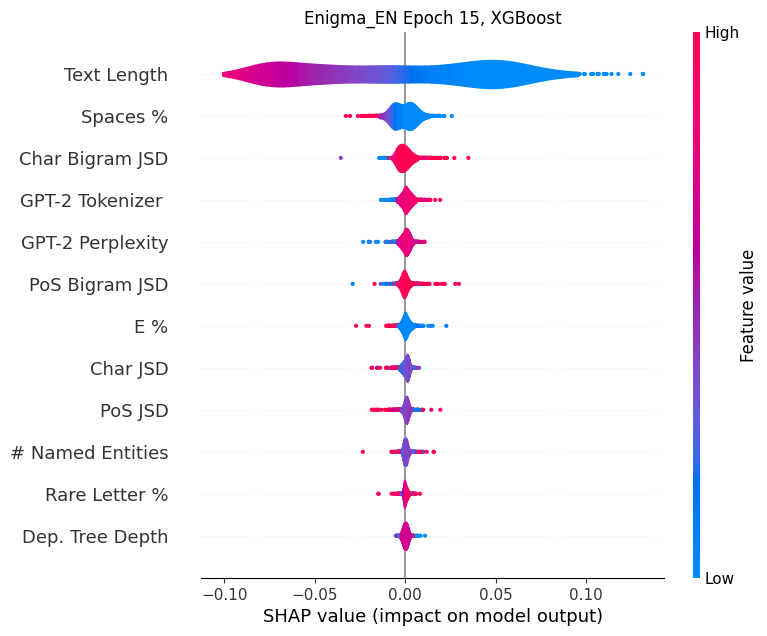

{'xgboost': (XGBRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, random_state=None, ...),
  0.5839432146146784,
  0.033160299950482225)}

In [9]:
# cs5enigma

pred_eval_checkpoint("en", "enigma", 15, save_charts=True, save_num=True)

en enigma 5 mean MAE: 0.0620154537392819, R2: -2.7125753984114098e-05
en enigma 5 ridge MAE: 0.021576228132660538, R2: 0.860096361299148
en enigma 5 xgboost MAE: 0.01937601757733499, R2: 0.8867632638373356
en enigma 5 randomforest MAE: 0.019495645692038995, R2: 0.8870763038281563
en enigma 5 mlp MAE: 0.020742671765160287, R2: 0.8707578692329522


 99%|===================| 9908/10000 [00:46<00:00]        

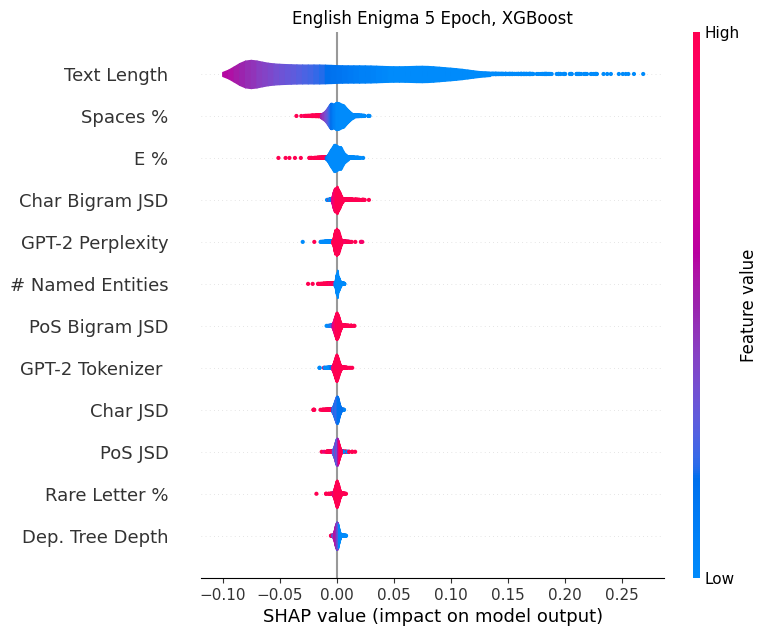

Processed en enigma 5 in 332.04426622390747 seconds
en enigma 10 mean MAE: 0.06294178509983635, R2: -1.0743775467725314e-05
en enigma 10 ridge MAE: 0.021753617559761167, R2: 0.8591130124278886
en enigma 10 xgboost MAE: 0.019752577015667374, R2: 0.8848154606119278
en enigma 10 randomforest MAE: 0.020002988660696348, R2: 0.8826586021509207
en enigma 10 mlp MAE: 0.020214863434947664, R2: 0.8797978607666626


 99%|===================| 9942/10000 [00:44<00:00]        

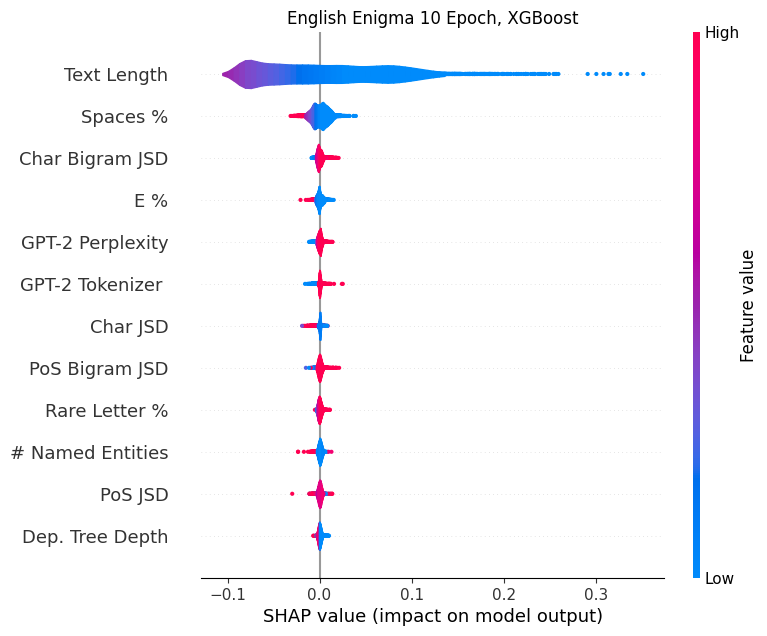

Processed en enigma 10 in 317.54020380973816 seconds
en enigma 15 mean MAE: 0.06155687758243964, R2: -7.348604850343499e-05
en enigma 15 ridge MAE: 0.03289628649707355, R2: 0.5986169600162113
en enigma 15 xgboost MAE: 0.033160299950482225, R2: 0.5839432146146784
en enigma 15 randomforest MAE: 0.03372761761032937, R2: 0.58413296923905
en enigma 15 mlp MAE: 0.03387724696595467, R2: 0.5864469850842612


 99%|===================| 9863/10000 [00:42<00:00]        

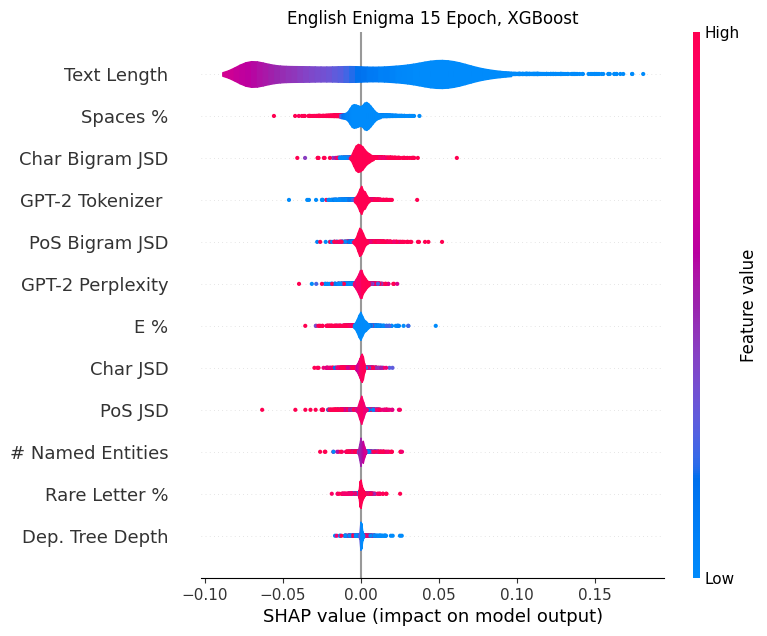

Processed en enigma 15 in 391.9583029747009 seconds
en enigma 20 mean MAE: 0.028360026624831107, R2: -4.8197873563138316e-05
en enigma 20 ridge MAE: 0.027116044715529364, R2: 0.0753449471216161
en enigma 20 xgboost MAE: 0.026838083442518586, R2: 0.08913140765295846
en enigma 20 randomforest MAE: 0.026812827946705715, R2: 0.09211583546035618
en enigma 20 mlp MAE: 0.02720140858956867, R2: 0.06552380425055515


 99%|===================| 9933/10000 [00:46<00:00]        

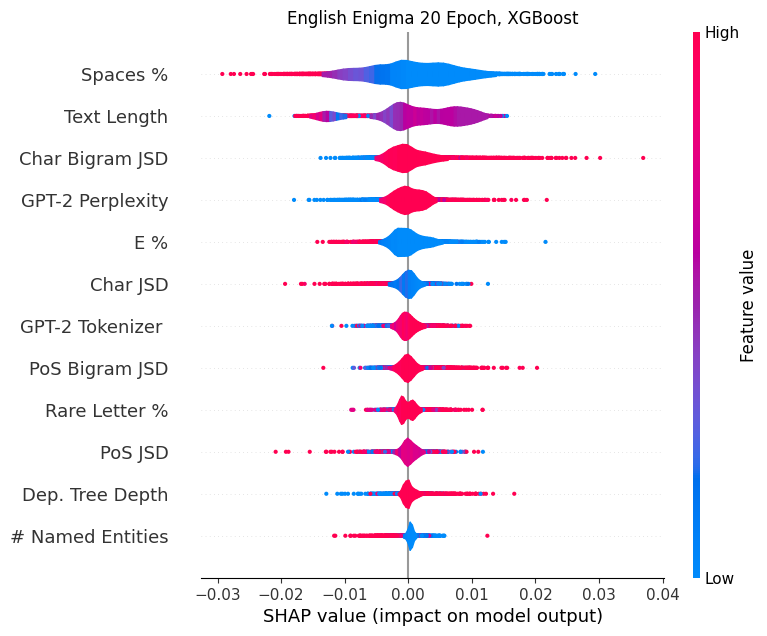

Processed en enigma 20 in 332.3645212650299 seconds
en enigma 25 mean MAE: 0.02594370809230596, R2: -7.595545408189963e-07
en enigma 25 ridge MAE: 0.024956031396959226, R2: 0.07234232012856179
en enigma 25 xgboost MAE: 0.025257106142532286, R2: 0.0482609142939634
en enigma 25 randomforest MAE: 0.025267054299189448, R2: 0.049687532093713904
en enigma 25 mlp MAE: 0.025866811170304795, R2: -0.011176499949943963


 98%|===================| 9812/10000 [00:46<00:00]        

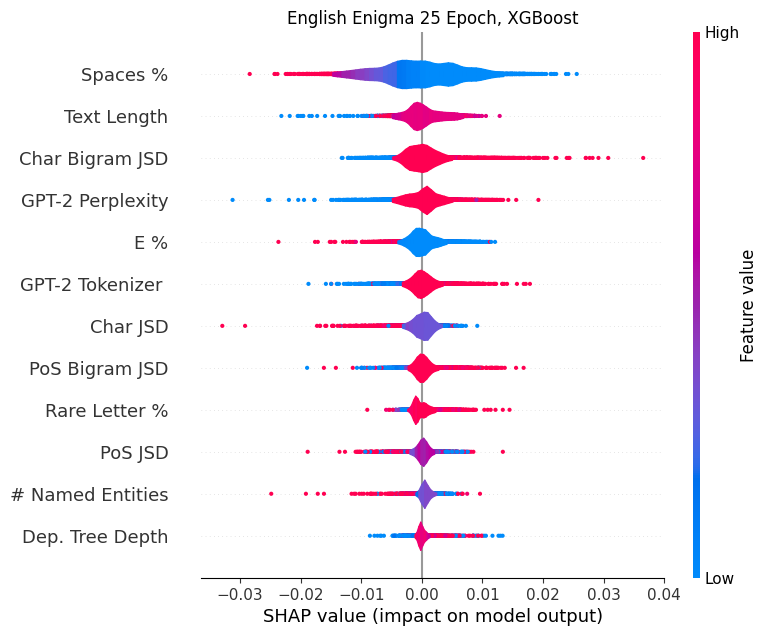

Processed en enigma 25 in 347.6351203918457 seconds
en enigma 30 mean MAE: 0.025000436275398965, R2: -1.7338132329403066e-05
en enigma 30 ridge MAE: 0.024020613024094906, R2: 0.0723669634248536
en enigma 30 xgboost MAE: 0.024364118232530773, R2: 0.04024420103234372
en enigma 30 randomforest MAE: 0.024313104645918102, R2: 0.04813389750795527
en enigma 30 mlp MAE: 0.025012325384530753, R2: -0.0013923917824665288


 99%|===================| 9935/10000 [00:46<00:00]        

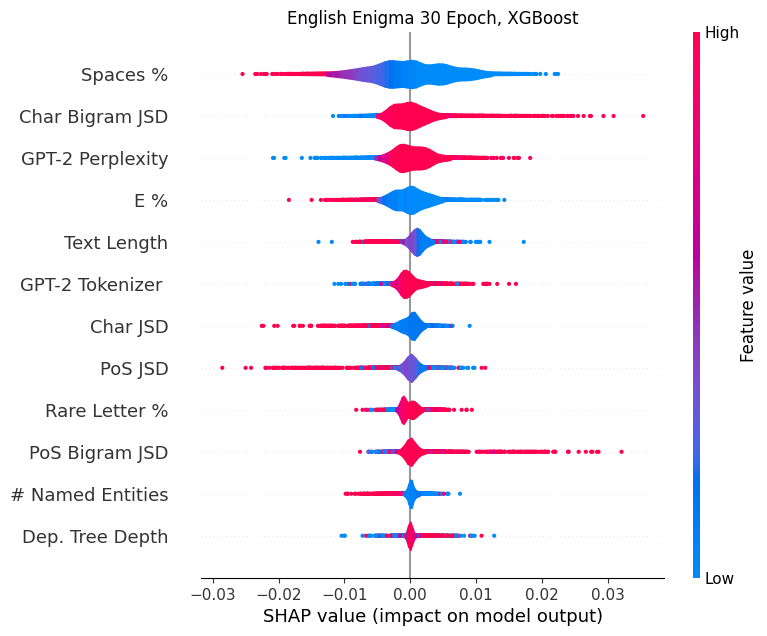

Processed en enigma 30 in 367.13876366615295 seconds
en enigma 35 mean MAE: 0.024981452974737105, R2: -1.9688100802994768e-05
en enigma 35 ridge MAE: 0.023890344722601424, R2: 0.0796636108834915
en enigma 35 xgboost MAE: 0.024175484232469863, R2: 0.05926095630912398
en enigma 35 randomforest MAE: 0.02408720163862244, R2: 0.06790099206340972
en enigma 35 mlp MAE: 0.0252359544285484, R2: -0.012391218859959086


 99%|===================| 9874/10000 [00:45<00:00]        

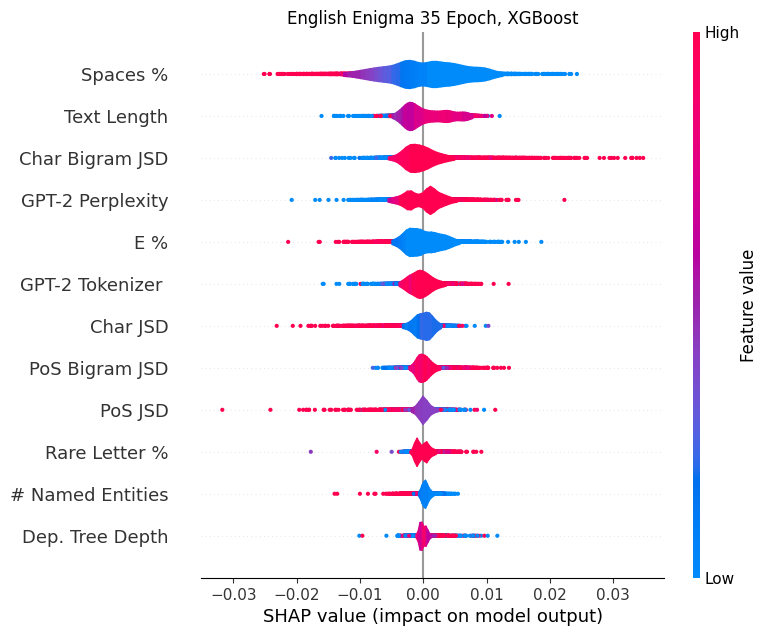

Processed en enigma 35 in 347.76920771598816 seconds
en enigma 40 mean MAE: 0.02470915125697976, R2: -2.918708539301207e-06
en enigma 40 ridge MAE: 0.023660004312726225, R2: 0.08214588524879796
en enigma 40 xgboost MAE: 0.024000928303886948, R2: 0.05957960886244984
en enigma 40 randomforest MAE: 0.023965588764271996, R2: 0.0647267576297389
en enigma 40 mlp MAE: 0.0250940645764194, R2: -0.02240190088027494


 99%|===================| 9891/10000 [00:45<00:00]        

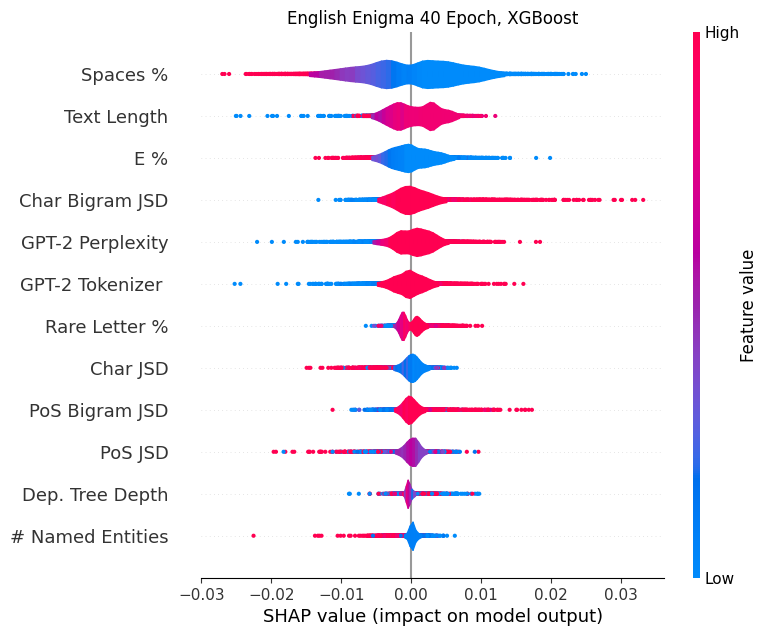

Processed en enigma 40 in 361.0996820926666 seconds
en vignere 5 mean MAE: 0.04371406542377624, R2: -7.417598847370144e-06
en vignere 5 ridge MAE: 0.04052482981866973, R2: 0.15468816197772828
en vignere 5 xgboost MAE: 0.04089632954767275, R2: 0.13795612481509156
en vignere 5 randomforest MAE: 0.04081471062021085, R2: 0.14015514090170555
en vignere 5 mlp MAE: 0.04089079712014388, R2: 0.13096870467738242


100%|===================| 9962/10000 [00:46<00:00]        

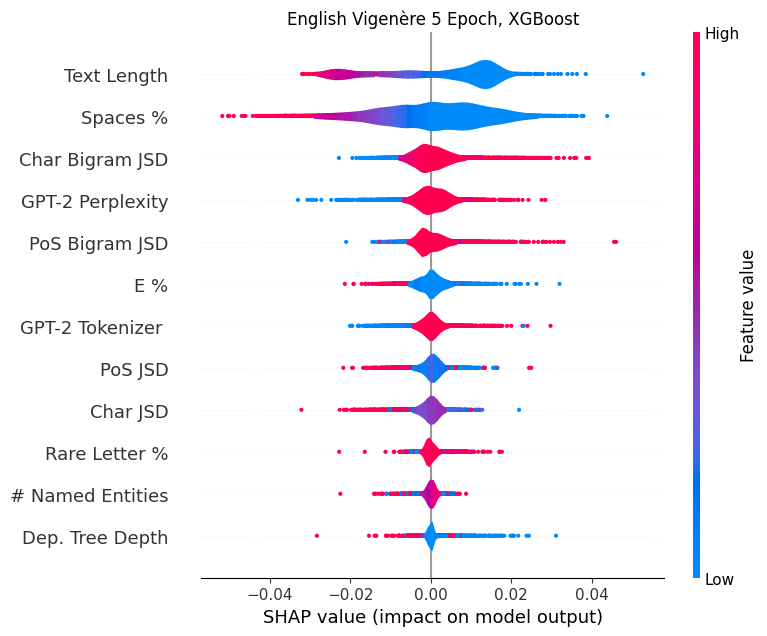

Processed en vignere 5 in 331.7210705280304 seconds
en vignere 10 mean MAE: 0.037319483808351754, R2: -0.00040570238152448646
en vignere 10 ridge MAE: 0.033802767420559154, R2: 0.16522445226975424
en vignere 10 xgboost MAE: 0.034304066769869246, R2: 0.14278709286544577
en vignere 10 randomforest MAE: 0.0344132748013352, R2: 0.14244701374440938
en vignere 10 mlp MAE: 0.03441131759329844, R2: 0.1207736987654433


 98%|===================| 9848/10000 [00:52<00:00]        

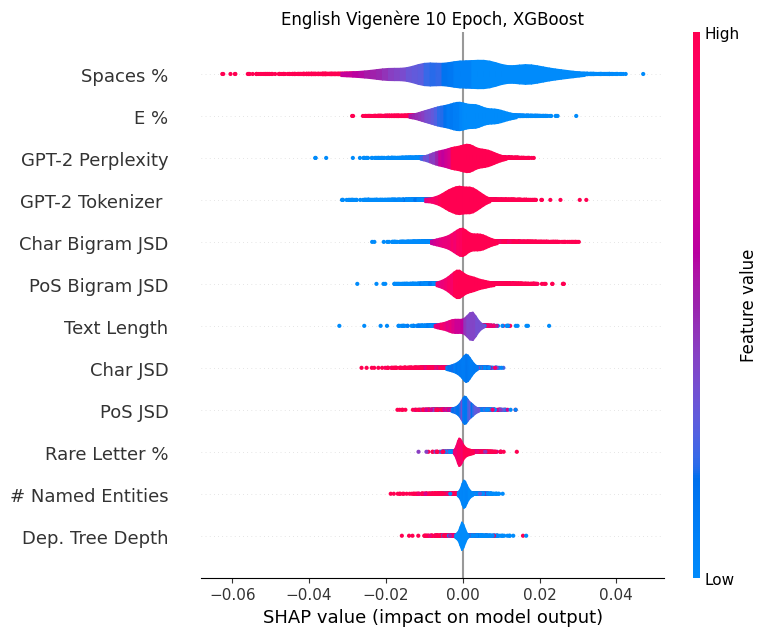

Processed en vignere 10 in 346.33105635643005 seconds
en vignere 15 mean MAE: 0.07141907196441871, R2: -7.788887437287784e-05
en vignere 15 ridge MAE: 0.06707244335135445, R2: 0.1258523283519707
en vignere 15 xgboost MAE: 0.06797113386189158, R2: 0.09923498564695854
en vignere 15 randomforest MAE: 0.06802415189269954, R2: 0.10715079723265863
en vignere 15 mlp MAE: 0.06711430568152849, R2: 0.1219068491949643


 98%|===================| 9833/10000 [00:48<00:00]        

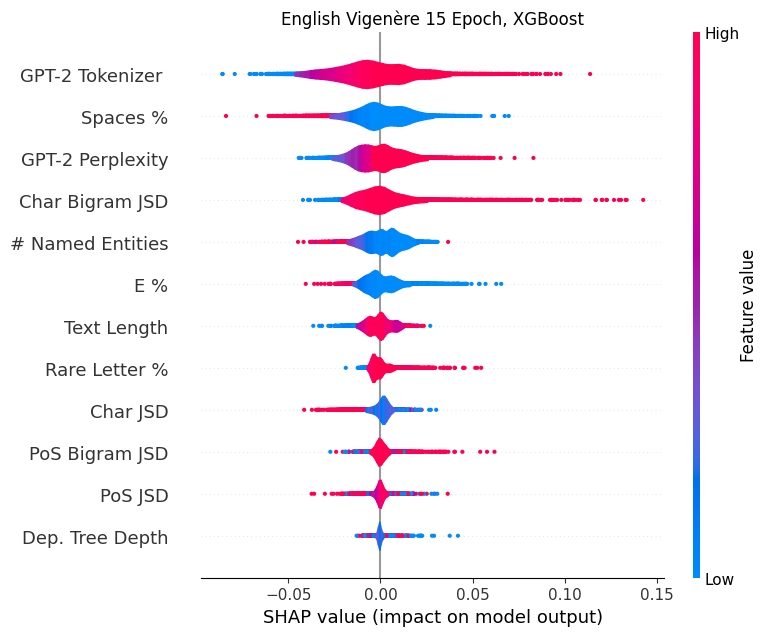

Processed en vignere 15 in 355.4843807220459 seconds
en vignere 20 mean MAE: 0.046234695775410964, R2: -2.598978650314443e-05
en vignere 20 ridge MAE: 0.04324247330379112, R2: 0.12382980554283596
en vignere 20 xgboost MAE: 0.043710604721208426, R2: 0.10663880095313882
en vignere 20 randomforest MAE: 0.04390037856925625, R2: 0.10658764734089743
en vignere 20 mlp MAE: 0.04311496148963912, R2: 0.12155804655447322


 99%|===================| 9898/10000 [00:49<00:00]        

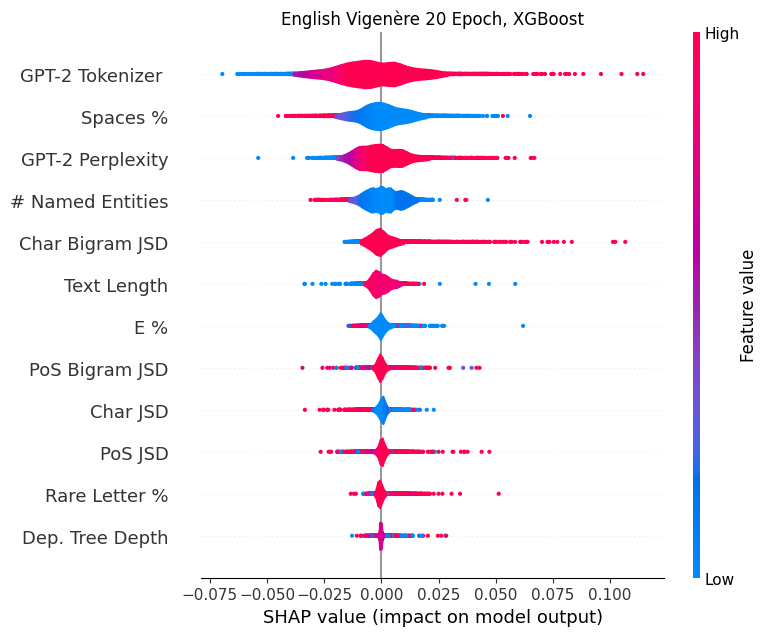

Processed en vignere 20 in 363.18054580688477 seconds
en vignere 25 mean MAE: 0.041477033826242155, R2: -8.911397485200645e-05
en vignere 25 ridge MAE: 0.038589593343576874, R2: 0.13309918699162826
en vignere 25 xgboost MAE: 0.03895898346464014, R2: 0.11255044534156422
en vignere 25 randomforest MAE: 0.039187206622499506, R2: 0.11225741345248319
en vignere 25 mlp MAE: 0.038929398480980114, R2: 0.12840514852501395


 99%|===================| 9884/10000 [00:48<00:00]        

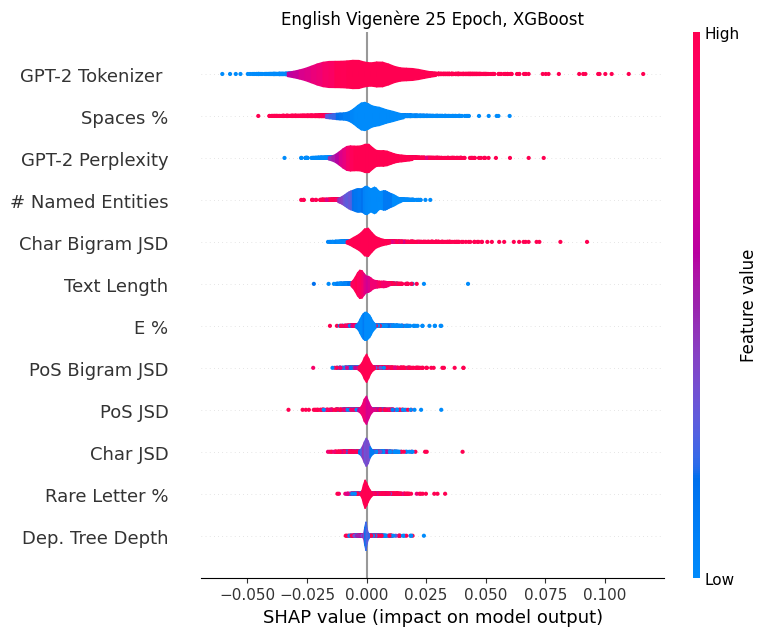

Processed en vignere 25 in 393.9784834384918 seconds
en vignere 30 mean MAE: 0.039450758614332164, R2: -6.142100444184173e-05
en vignere 30 ridge MAE: 0.0364998552701725, R2: 0.1401735430032245
en vignere 30 xgboost MAE: 0.03685895774431243, R2: 0.1221951942337327
en vignere 30 randomforest MAE: 0.037050622226116124, R2: 0.12110196395622697
en vignere 30 mlp MAE: 0.03626923592834611, R2: 0.1267476488399094


 98%|===================| 9794/10000 [00:48<00:01]        

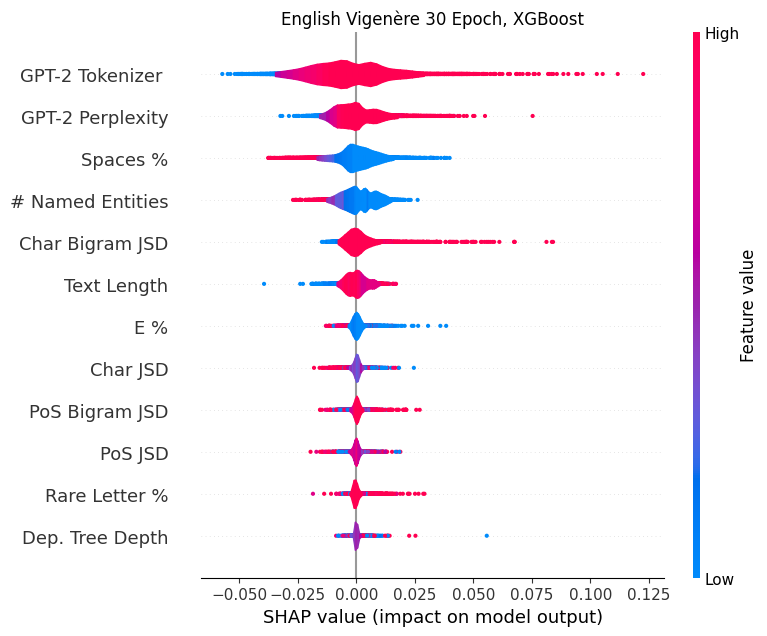

Processed en vignere 30 in 404.35362458229065 seconds
en vignere 35 mean MAE: 0.03877403874424391, R2: -0.00013922932765231266
en vignere 35 ridge MAE: 0.03576864999735425, R2: 0.1411990251427938
en vignere 35 xgboost MAE: 0.03618189765653088, R2: 0.11992611932619301
en vignere 35 randomforest MAE: 0.03635023699914239, R2: 0.12134938372075676
en vignere 35 mlp MAE: 0.036218635426835656, R2: 0.12274552644858627


 99%|===================| 9876/10000 [00:50<00:00]        

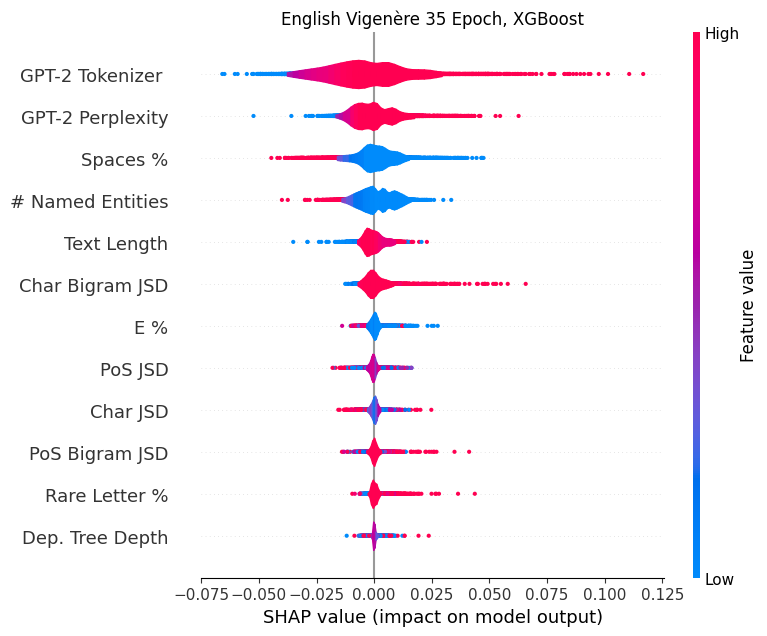

Processed en vignere 35 in 386.74054408073425 seconds
en vignere 40 mean MAE: 0.038189069167735186, R2: -3.90989459659874e-05
en vignere 40 ridge MAE: 0.03546580079763874, R2: 0.13660516427142388
en vignere 40 xgboost MAE: 0.0359208703018719, R2: 0.11471585526648698
en vignere 40 randomforest MAE: 0.036038065496691286, R2: 0.11926156482744266
en vignere 40 mlp MAE: 0.036091254574836126, R2: 0.12633985771900913


 99%|===================| 9885/10000 [00:49<00:00]        

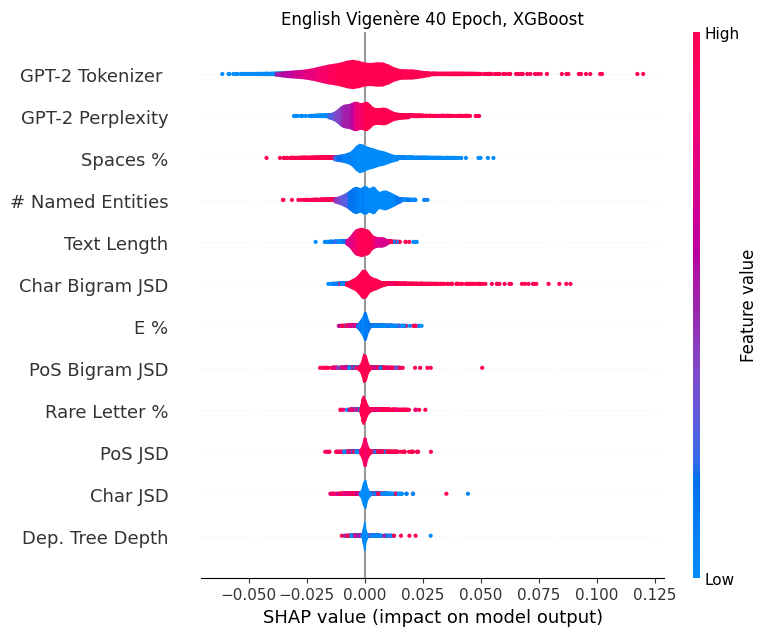

Processed en vignere 40 in 366.1578719615936 seconds
cs enigma 5 mean MAE: 0.06423267925026967, R2: -0.0002246813857760266
cs enigma 5 ridge MAE: 0.024345808670230878, R2: 0.839450809166665
cs enigma 5 xgboost MAE: 0.02229136724998276, R2: 0.8680328338581299
cs enigma 5 randomforest MAE: 0.022411615809211985, R2: 0.8668891406611722
cs enigma 5 mlp MAE: 0.02437521173233852, R2: 0.8457735780836209


 99%|===================| 9867/10000 [00:48<00:00]        

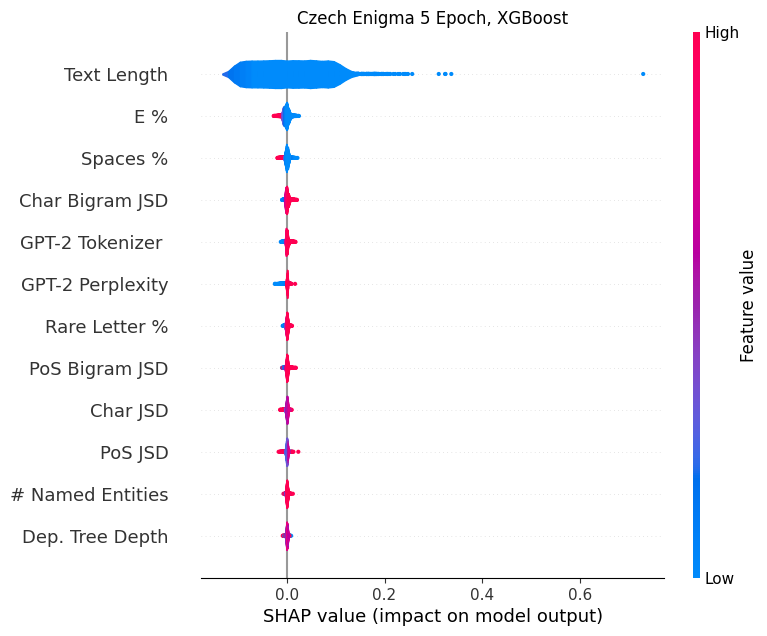

Processed cs enigma 5 in 332.20020937919617 seconds
cs enigma 10 mean MAE: 0.0711183629831929, R2: -6.752603314130745e-05
cs enigma 10 ridge MAE: 0.06519273142912305, R2: 0.17318936820316844
cs enigma 10 xgboost MAE: 0.06592665344108627, R2: 0.14077149965351854
cs enigma 10 randomforest MAE: 0.06575123457061292, R2: 0.1574331585380212
cs enigma 10 mlp MAE: 0.06563361315122312, R2: 0.1504629784091419


100%|===================| 9955/10000 [00:44<00:00]        

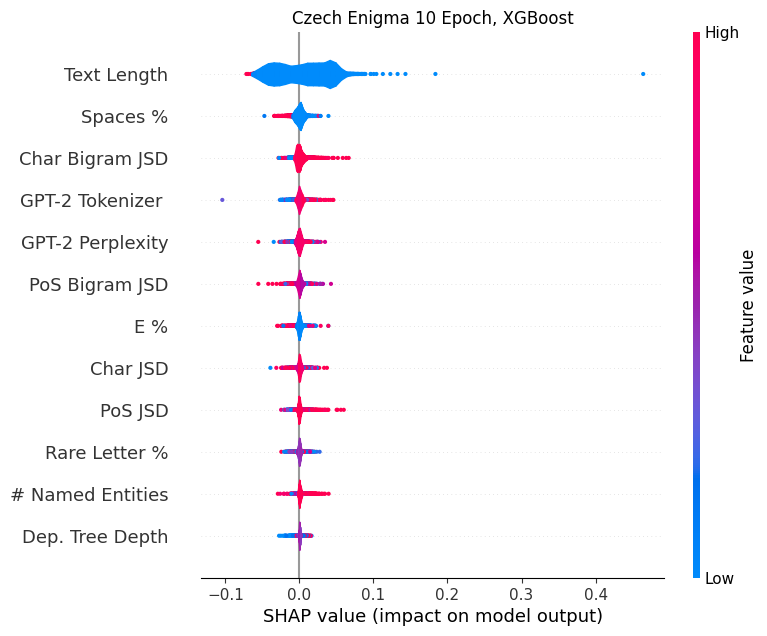

Processed cs enigma 10 in 360.86843752861023 seconds
cs enigma 15 mean MAE: 0.03269382034154101, R2: -4.2230605105775254e-05
cs enigma 15 ridge MAE: 0.03191017557180061, R2: 0.041490162760957516
cs enigma 15 xgboost MAE: 0.031038486777526252, R2: 0.07165394742625375
cs enigma 15 randomforest MAE: 0.030966870306075804, R2: 0.07805673880199637
cs enigma 15 mlp MAE: 0.031358820034358616, R2: 0.05740969463023404


 99%|===================| 9921/10000 [00:46<00:00]        

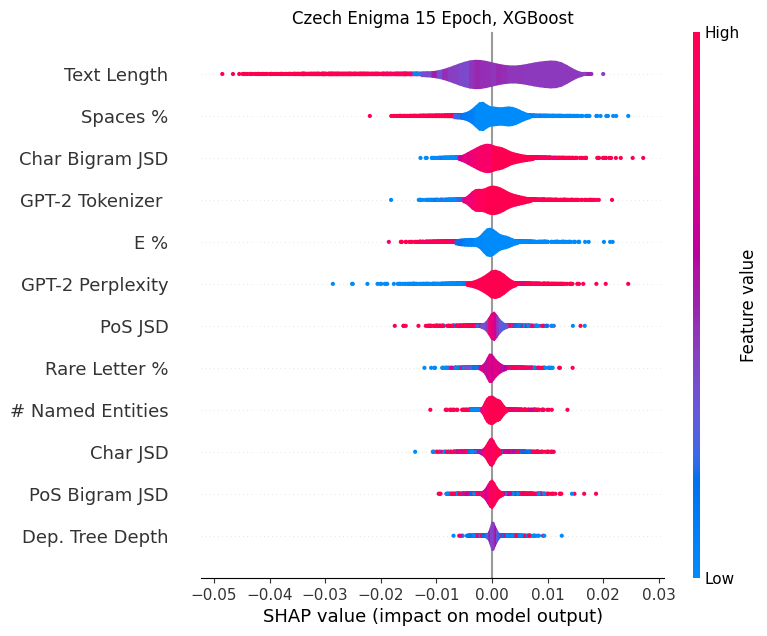

Processed cs enigma 15 in 362.221871137619 seconds
cs enigma 20 mean MAE: 0.02856548056359602, R2: -4.268417906572175e-05
cs enigma 20 ridge MAE: 0.028077492356162, R2: 0.034947366301869676
cs enigma 20 xgboost MAE: 0.02797439507596937, R2: 0.037739640949598696
cs enigma 20 randomforest MAE: 0.027789552162462258, R2: 0.051413591217514765
cs enigma 20 mlp MAE: 0.028742918005443766, R2: -0.020518513767449953


100%|===================| 9951/10000 [00:47<00:00]        

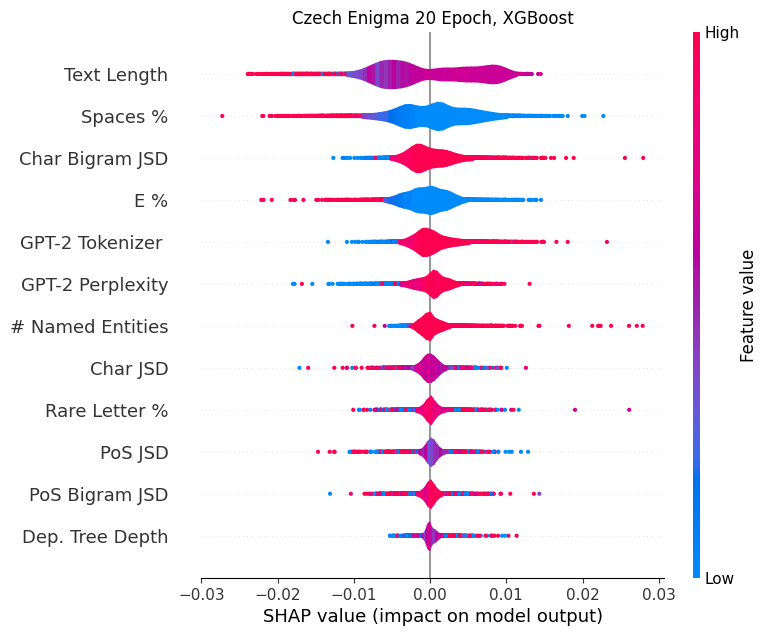

Processed cs enigma 20 in 360.8486590385437 seconds
cs enigma 25 mean MAE: 0.02900577996408707, R2: -9.506516161894574e-05
cs enigma 25 ridge MAE: 0.028570468882174453, R2: 0.03039700673476231
cs enigma 25 xgboost MAE: 0.027869967172458227, R2: 0.0651602108532987
cs enigma 25 randomforest MAE: 0.027961209570442683, R2: 0.06319707530045793
cs enigma 25 mlp MAE: 0.02846049832821349, R2: 0.02580662915521892


 99%|===================| 9914/10000 [00:46<00:00]        

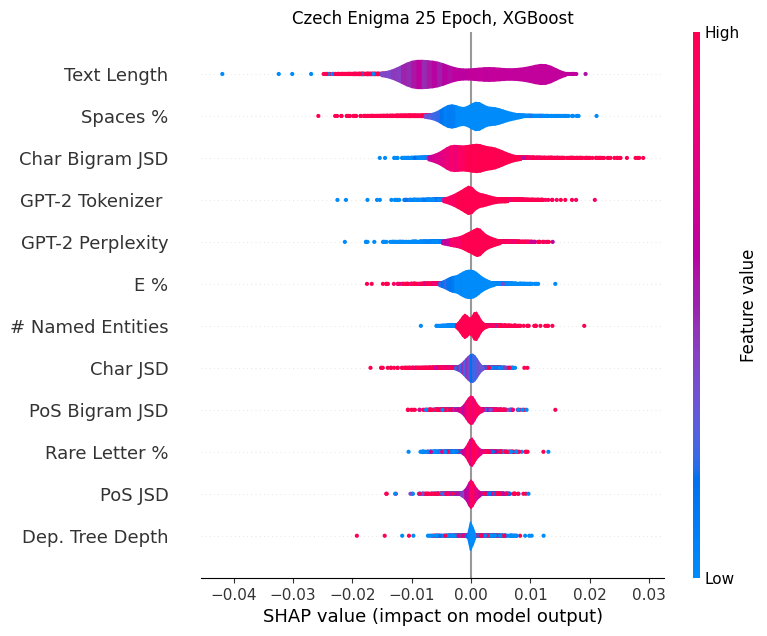

Processed cs enigma 25 in 399.5996603965759 seconds
cs enigma 30 mean MAE: 0.030566765261930622, R2: -5.366333999390349e-08
cs enigma 30 ridge MAE: 0.030024814747473438, R2: 0.035611397958596136
cs enigma 30 xgboost MAE: 0.029516801868970606, R2: 0.05844962947413124
cs enigma 30 randomforest MAE: 0.029529599996755723, R2: 0.06058401713184436
cs enigma 30 mlp MAE: 0.030251128646878726, R2: 0.011891348022212922


 99%|===================| 9904/10000 [00:49<00:00]        

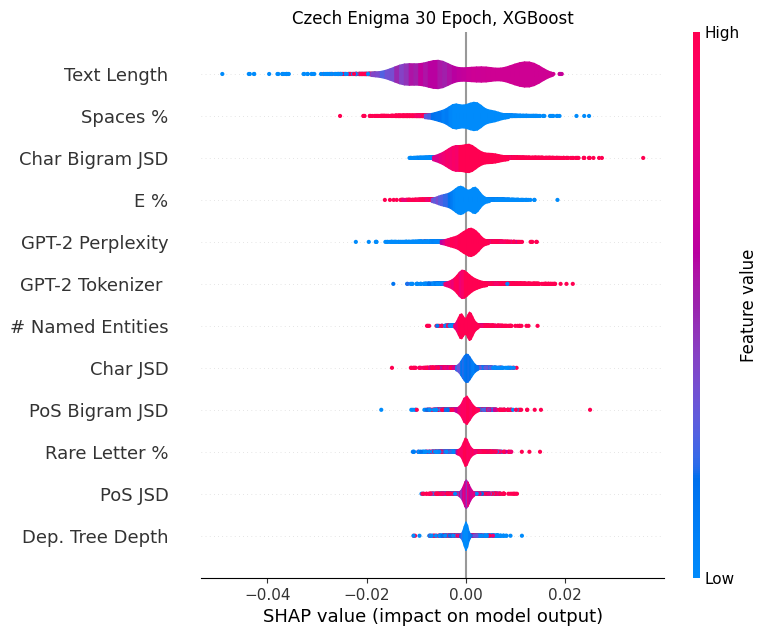

Processed cs enigma 30 in 393.93434739112854 seconds
cs enigma 35 mean MAE: 0.03132846578637154, R2: -0.0003539915144012973
cs enigma 35 ridge MAE: 0.03059805136522629, R2: 0.04527439449849946
cs enigma 35 xgboost MAE: 0.03036217414220028, R2: 0.05725733397399224
cs enigma 35 randomforest MAE: 0.03033872305817594, R2: 0.0595037988154542
cs enigma 35 mlp MAE: 0.03076661372612032, R2: 0.019614638376792337


 99%|===================| 9856/10000 [00:46<00:00]        

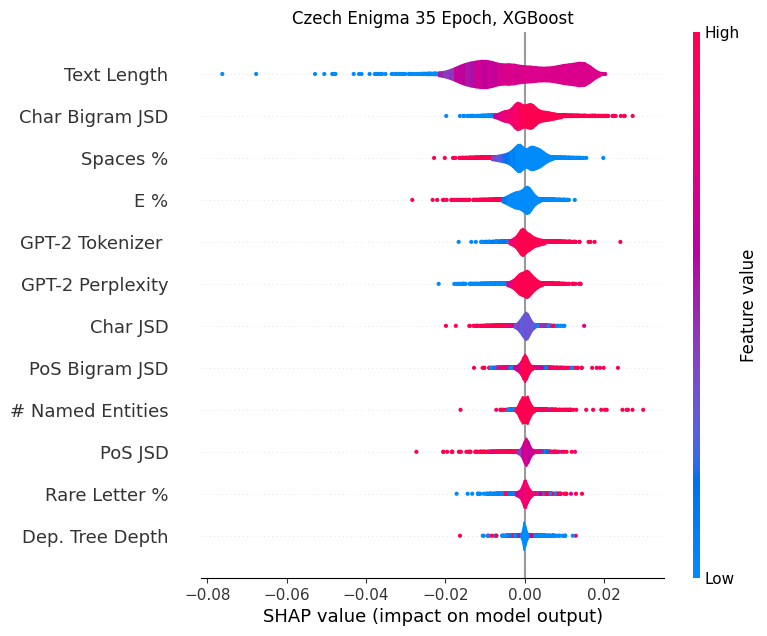

Processed cs enigma 35 in 344.6003851890564 seconds
cs enigma 40 mean MAE: 0.031874954114477355, R2: -2.8358201535017002e-05
cs enigma 40 ridge MAE: 0.031125825618426837, R2: 0.047538245172835225
cs enigma 40 xgboost MAE: 0.031215860603523226, R2: 0.03716148303160394
cs enigma 40 randomforest MAE: 0.031094634202165485, R2: 0.04413874204851442
cs enigma 40 mlp MAE: 0.03174467861517086, R2: 0.016097168518396376


 99%|===================| 9875/10000 [00:48<00:00]        

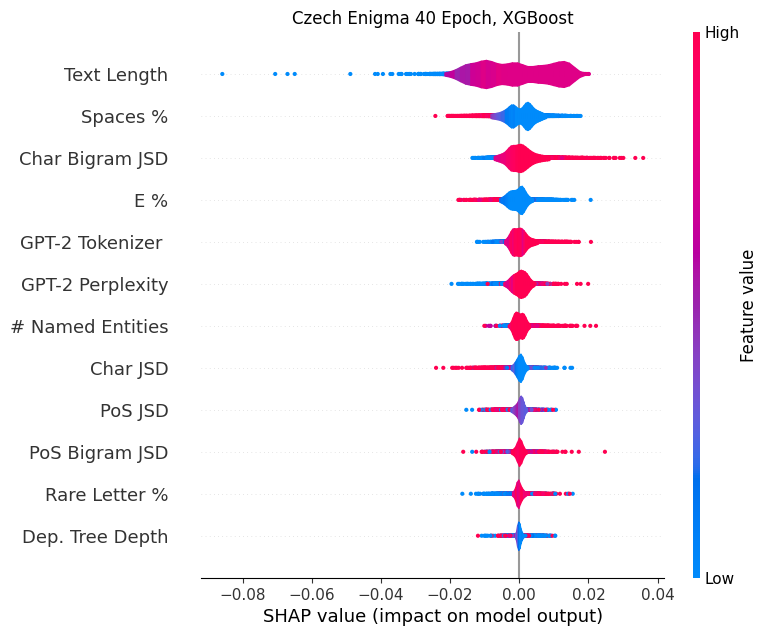

Processed cs enigma 40 in 365.543740272522 seconds
cs vignere 5 mean MAE: 0.04637868227964475, R2: -0.0006022942447341251
cs vignere 5 ridge MAE: 0.0412500956163577, R2: 0.1988428904550732
cs vignere 5 xgboost MAE: 0.04162191643087348, R2: 0.18077141390371465
cs vignere 5 randomforest MAE: 0.041520131098742585, R2: 0.1845665025122868
cs vignere 5 mlp MAE: 0.04178839760163421, R2: 0.18457384062147897


100%|===================| 9967/10000 [00:49<00:00]        

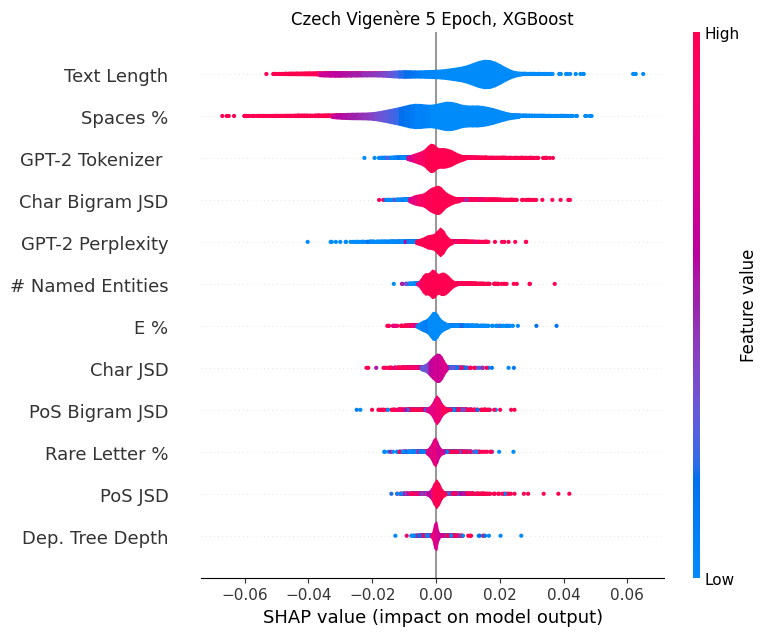

Processed cs vignere 5 in 346.015305519104 seconds
cs vignere 10 mean MAE: 0.028549786220585894, R2: -2.2134400683659905e-05
cs vignere 10 ridge MAE: 0.026475414767014524, R2: 0.14152600424838246
cs vignere 10 xgboost MAE: 0.026742124485167107, R2: 0.12349407345867414
cs vignere 10 randomforest MAE: 0.02679489529276775, R2: 0.12333426104499778
cs vignere 10 mlp MAE: 0.030623855078909946, R2: -0.10177101745834904


 99%|===================| 9882/10000 [00:47<00:00]        

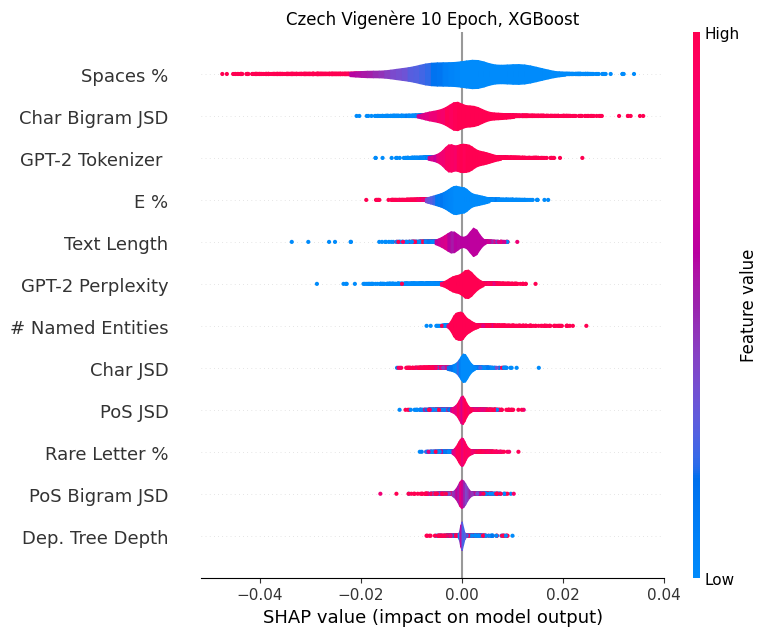

Processed cs vignere 10 in 384.03961277008057 seconds
cs vignere 15 mean MAE: 0.03600874657447233, R2: -1.5354095996844563e-06
cs vignere 15 ridge MAE: 0.03351656098947617, R2: 0.12745006826091032
cs vignere 15 xgboost MAE: 0.033948366471752825, R2: 0.10407851330620133
cs vignere 15 randomforest MAE: 0.03407148846024012, R2: 0.10257469271783493
cs vignere 15 mlp MAE: 0.03622981433786089, R2: 0.03337589961315224


100%|===================| 9956/10000 [00:47<00:00]        

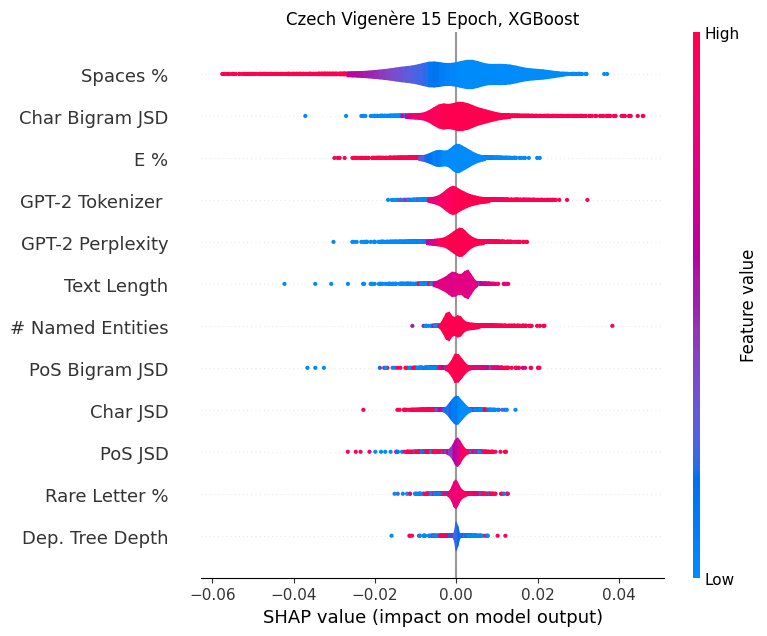

Processed cs vignere 15 in 362.5211887359619 seconds
cs vignere 20 mean MAE: 0.09249413966387653, R2: -1.3524693409872057e-05
cs vignere 20 ridge MAE: 0.08910450326022035, R2: 0.07478262770163635
cs vignere 20 xgboost MAE: 0.08954743263392063, R2: 0.057818277197243195
cs vignere 20 randomforest MAE: 0.08953137047818184, R2: 0.06461138229099606
cs vignere 20 mlp MAE: 0.08896252837537352, R2: 0.07467688559484231


 99%|===================| 9902/10000 [00:49<00:00]        

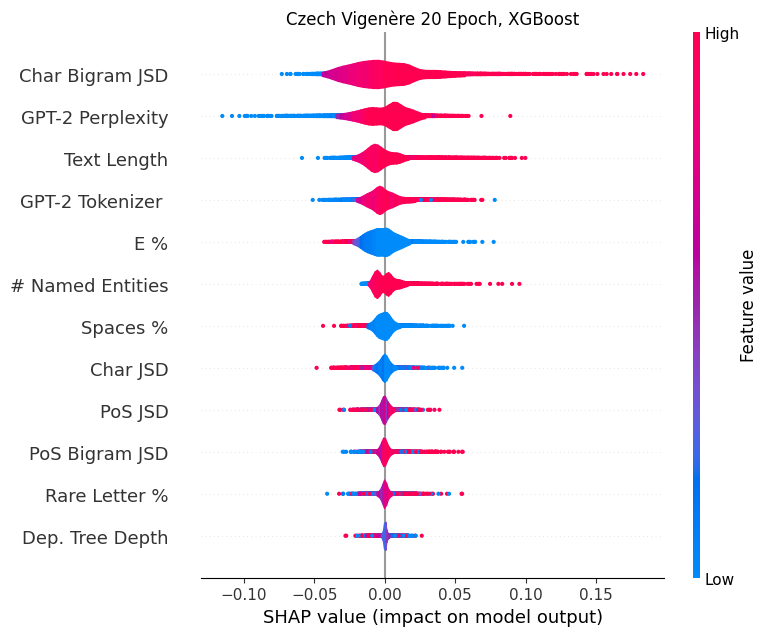

Processed cs vignere 20 in 368.7439193725586 seconds
cs vignere 25 mean MAE: 0.05646494906782484, R2: -0.00010831138914979554
cs vignere 25 ridge MAE: 0.05495405146138562, R2: 0.05891149164803111
cs vignere 25 xgboost MAE: 0.05494909360028599, R2: 0.04943916673067472
cs vignere 25 randomforest MAE: 0.0552355490875841, R2: 0.05126762429038745
cs vignere 25 mlp MAE: 0.05443338472062245, R2: 0.056683478452391745


 98%|===================| 9782/10000 [00:47<00:01]        

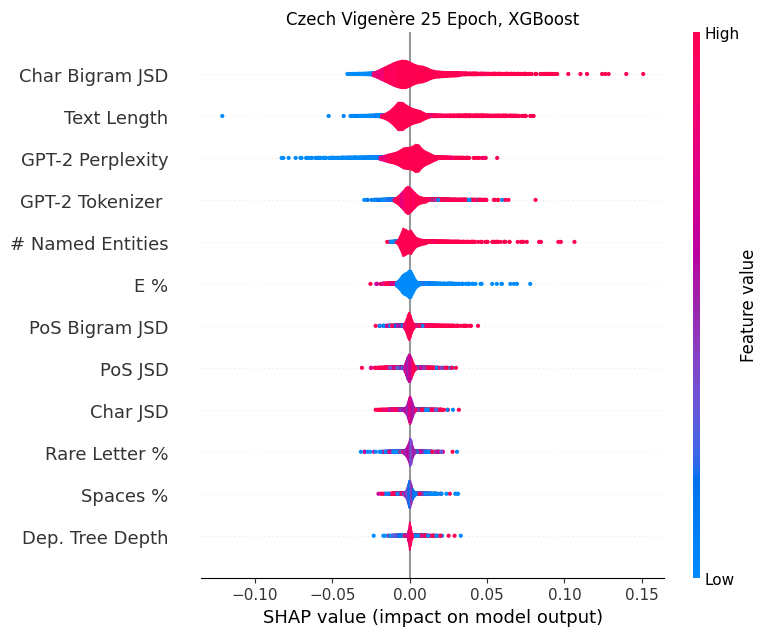

Processed cs vignere 25 in 395.39163994789124 seconds
cs vignere 30 mean MAE: 0.05151234456338137, R2: -0.00022256343066007211
cs vignere 30 ridge MAE: 0.050097889726020126, R2: 0.05701188434135285
cs vignere 30 xgboost MAE: 0.050071376655208735, R2: 0.051405265286226465
cs vignere 30 randomforest MAE: 0.05066974499644358, R2: 0.048417551229990696
cs vignere 30 mlp MAE: 0.05018817257461837, R2: 0.06210408489200103


 99%|===================| 9894/10000 [00:45<00:00]        

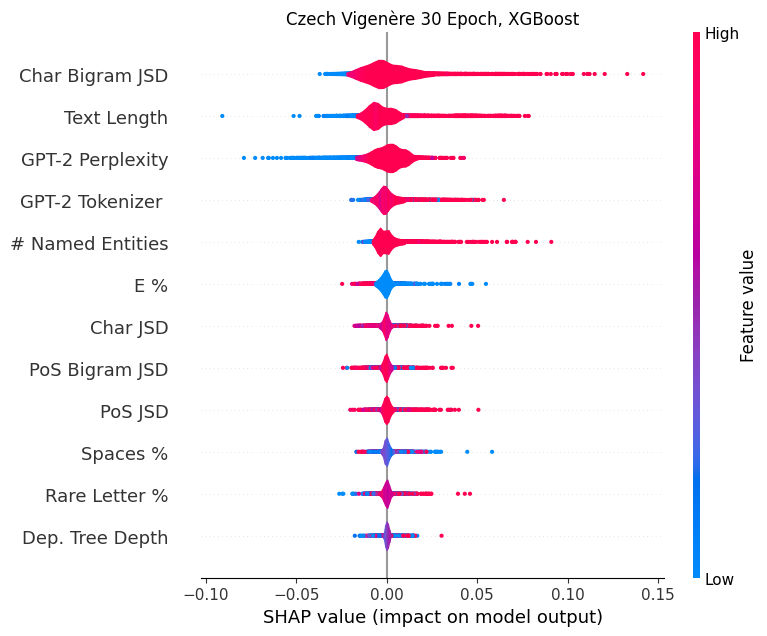

Processed cs vignere 30 in 379.3715786933899 seconds
cs vignere 35 mean MAE: 0.04968480767246732, R2: -9.946745661326695e-05
cs vignere 35 ridge MAE: 0.04850288882378242, R2: 0.05275911928280308
cs vignere 35 xgboost MAE: 0.048496502307859256, R2: 0.050747738330849224
cs vignere 35 randomforest MAE: 0.0488104435541775, R2: 0.0484644303095666
cs vignere 35 mlp MAE: 0.04961269612925852, R2: 0.04808701806591276


 99%|===================| 9914/10000 [00:45<00:00]        

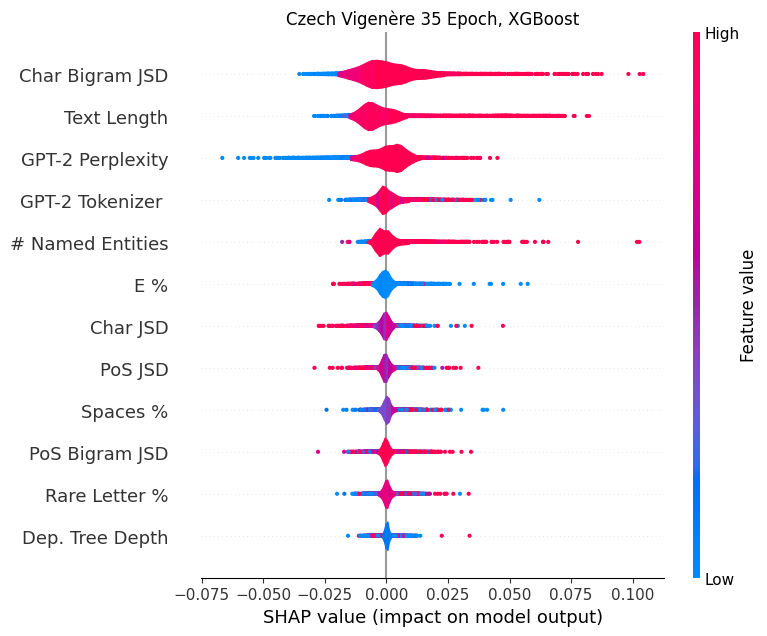

Processed cs vignere 35 in 411.18486404418945 seconds
cs vignere 40 mean MAE: 0.04786507618823717, R2: -0.0001916513738295933
cs vignere 40 ridge MAE: 0.046753870203102094, R2: 0.052032327343007445
cs vignere 40 xgboost MAE: 0.046715582553062567, R2: 0.05200690420891385
cs vignere 40 randomforest MAE: 0.0470179079432145, R2: 0.04847180519151317
cs vignere 40 mlp MAE: 0.0466584508176286, R2: 0.06738391301928104


 98%|===================| 9827/10000 [00:45<00:00]        

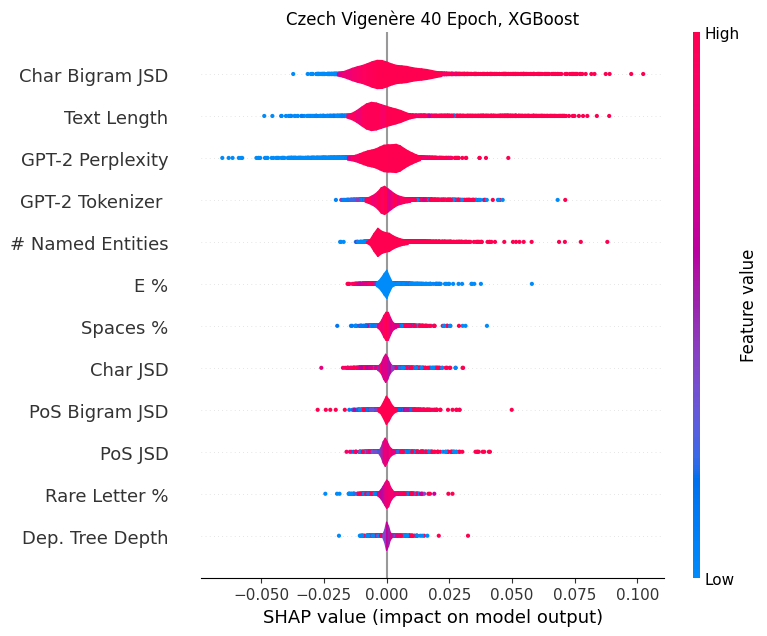

Processed cs vignere 40 in 391.55060267448425 seconds
de enigma 5 mean MAE: 0.039604572717185954, R2: -9.209970563972547e-10
de enigma 5 ridge MAE: 0.03459420160437307, R2: 0.2026078818495698
de enigma 5 xgboost MAE: 0.032886088407229036, R2: 0.26600465398758566
de enigma 5 randomforest MAE: 0.03301488144234228, R2: 0.2654890854596229
de enigma 5 mlp MAE: 0.034248679195819635, R2: 0.20232045254266662


 99%|===================| 9878/10000 [00:50<00:00]        

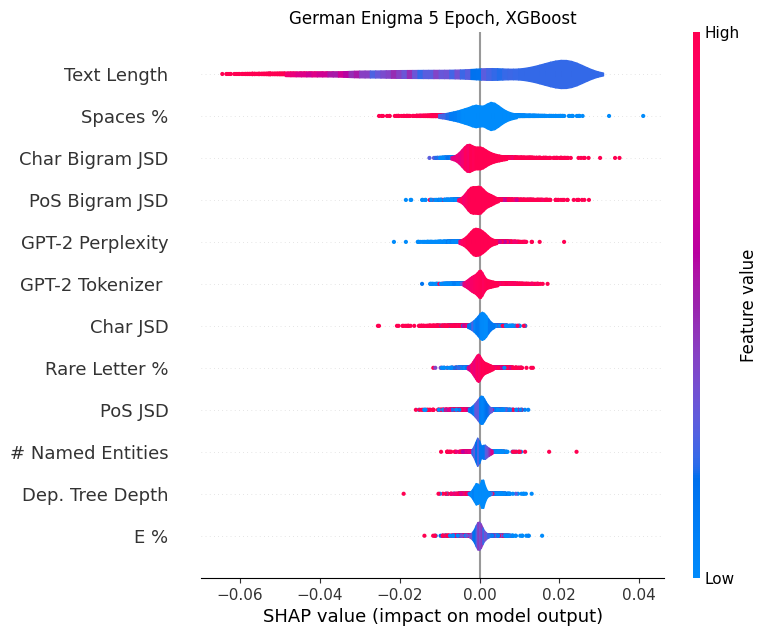

Processed de enigma 5 in 362.86274433135986 seconds
de enigma 10 mean MAE: 0.046926402875711655, R2: -3.0524127998088346e-05
de enigma 10 ridge MAE: 0.04130397151593366, R2: 0.19606781967840403
de enigma 10 xgboost MAE: 0.041298574988443706, R2: 0.1858597695697709
de enigma 10 randomforest MAE: 0.04119410991343429, R2: 0.19466332800165687
de enigma 10 mlp MAE: 0.04164763020886809, R2: 0.1728257673655802


 99%|===================| 9862/10000 [00:50<00:00]        

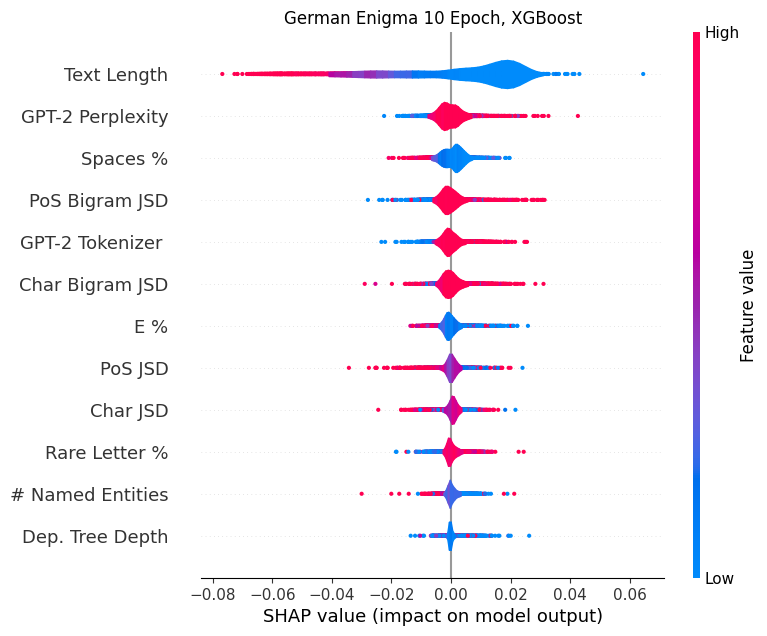

Processed de enigma 10 in 364.02723240852356 seconds
de enigma 15 mean MAE: 0.029655263693990196, R2: -2.194533718746783e-06
de enigma 15 ridge MAE: 0.028921961895237023, R2: 0.04615480396064087
de enigma 15 xgboost MAE: 0.028962531784887356, R2: 0.04172859104098592
de enigma 15 randomforest MAE: 0.02905464259527149, R2: 0.03678251176426317
de enigma 15 mlp MAE: 0.029339330125804804, R2: 0.013551318057911765


 98%|===================| 9790/10000 [00:47<00:01]        

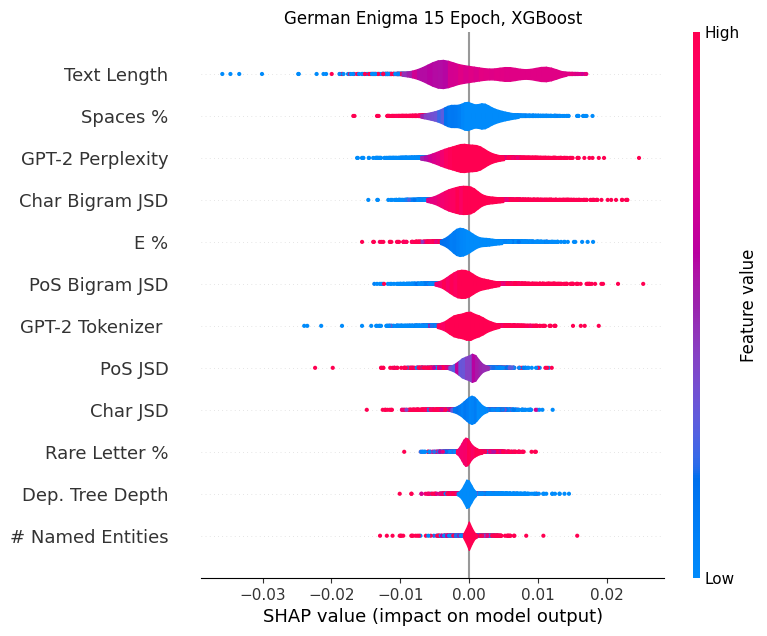

Processed de enigma 15 in 355.32680916786194 seconds
de enigma 20 mean MAE: 0.031287909533203664, R2: -1.4396852561215923e-06
de enigma 20 ridge MAE: 0.030448186375765397, R2: 0.05778334369705607
de enigma 20 xgboost MAE: 0.030011782033714945, R2: 0.07462526184884721
de enigma 20 randomforest MAE: 0.03004786023086361, R2: 0.07726382882341032
de enigma 20 mlp MAE: 0.03120245967172515, R2: 0.010626796488492851


 98%|===================| 9823/10000 [00:47<00:00]        

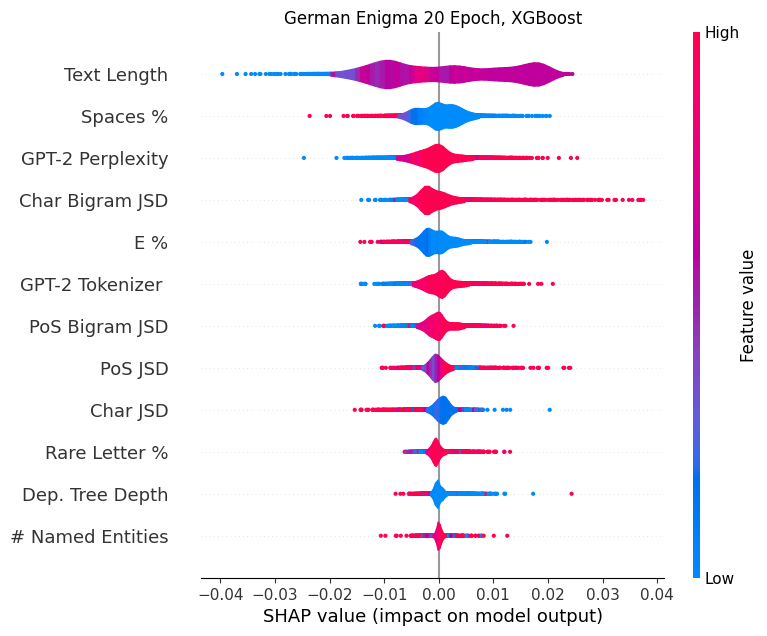

Processed de enigma 20 in 354.6500070095062 seconds
de enigma 25 mean MAE: 0.032447654659128855, R2: -0.00010077898852278722
de enigma 25 ridge MAE: 0.03139539517190634, R2: 0.06170272461685811
de enigma 25 xgboost MAE: 0.03162196321044194, R2: 0.04921798019091639
de enigma 25 randomforest MAE: 0.03146000375616602, R2: 0.05717341457174929
de enigma 25 mlp MAE: 0.03236099092604551, R2: 0.013533648630646766


 99%|===================| 9906/10000 [00:48<00:00]        

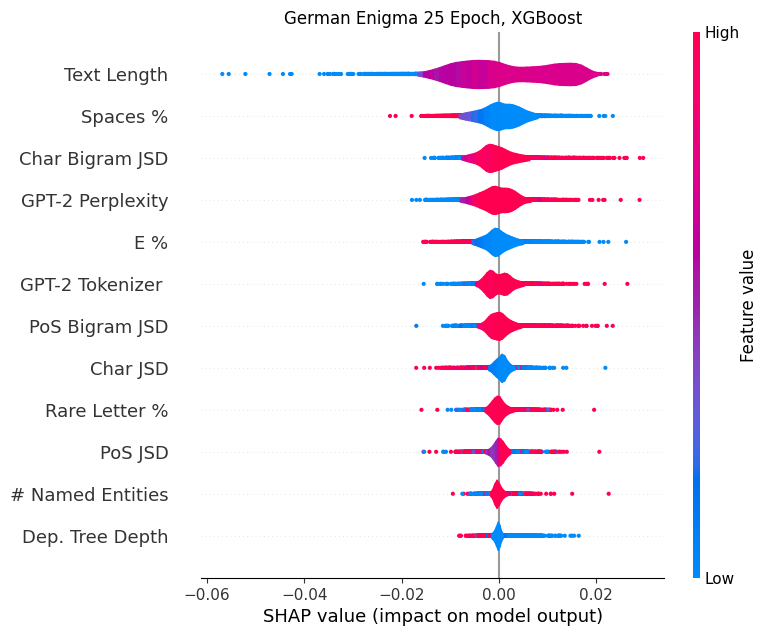

Processed de enigma 25 in 378.8458173274994 seconds
de enigma 30 mean MAE: 0.03404536023525066, R2: -0.00036163874810157814
de enigma 30 ridge MAE: 0.03298606684847551, R2: 0.060121463966104516
de enigma 30 xgboost MAE: 0.032755848314359945, R2: 0.06596434534371376
de enigma 30 randomforest MAE: 0.03284499273879856, R2: 0.06866695914501098
de enigma 30 mlp MAE: 0.03597022930301033, R2: -0.1273630893394313


 98%|===================| 9840/10000 [00:49<00:00]        

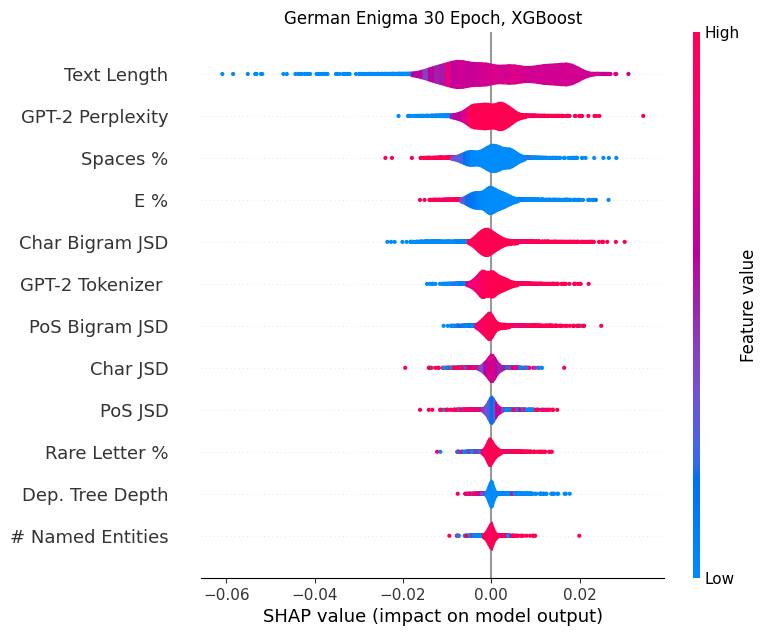

Processed de enigma 30 in 358.69846272468567 seconds
de enigma 35 mean MAE: 0.03620969563835553, R2: -3.886458608493015e-06
de enigma 35 ridge MAE: 0.03490324704017841, R2: 0.07004518392925385
de enigma 35 xgboost MAE: 0.03481981034762541, R2: 0.07180556153510564
de enigma 35 randomforest MAE: 0.03473662371831205, R2: 0.07592357877421918
de enigma 35 mlp MAE: 0.03684645369824357, R2: -0.019052808722212156


 99%|===================| 9930/10000 [00:48<00:00]        

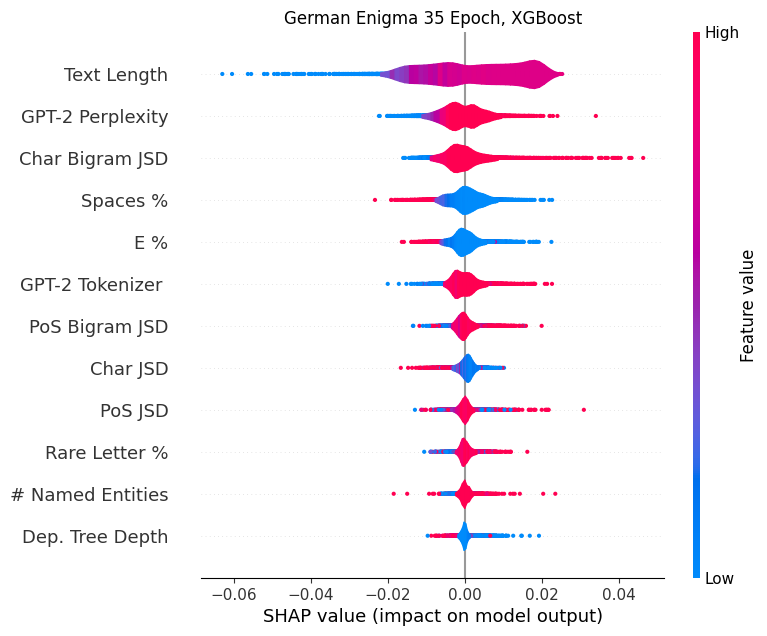

Processed de enigma 35 in 346.14802956581116 seconds
de enigma 40 mean MAE: 0.036867608867649226, R2: -0.00030402619281422183
de enigma 40 ridge MAE: 0.03546061109694969, R2: 0.0747030063125399
de enigma 40 xgboost MAE: 0.03547480463547468, R2: 0.06694633832268482
de enigma 40 randomforest MAE: 0.03552039471618754, R2: 0.06725681879208589
de enigma 40 mlp MAE: 0.03621904891966011, R2: 0.038856460047681285


 99%|===================| 9885/10000 [00:49<00:00]        

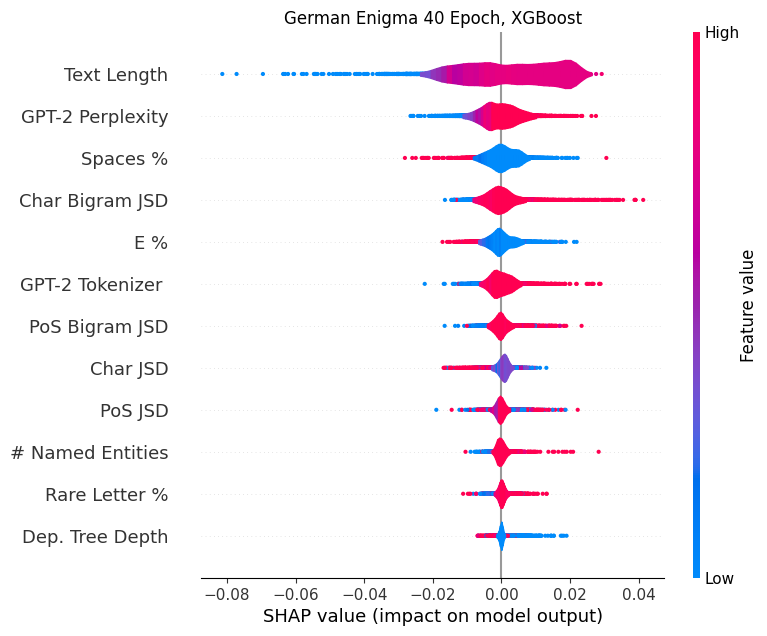

Processed de enigma 40 in 356.6343984603882 seconds
de vignere 5 mean MAE: 0.048657233827719186, R2: -4.0561585147758095e-05
de vignere 5 ridge MAE: 0.044949703173771616, R2: 0.15529328268845133
de vignere 5 xgboost MAE: 0.045601657872813055, R2: 0.12719395786007914
de vignere 5 randomforest MAE: 0.04553980065881226, R2: 0.13242030675098582
de vignere 5 mlp MAE: 0.046478476007817196, R2: 0.08960250620761656


100%|===================| 9979/10000 [00:49<00:00]        

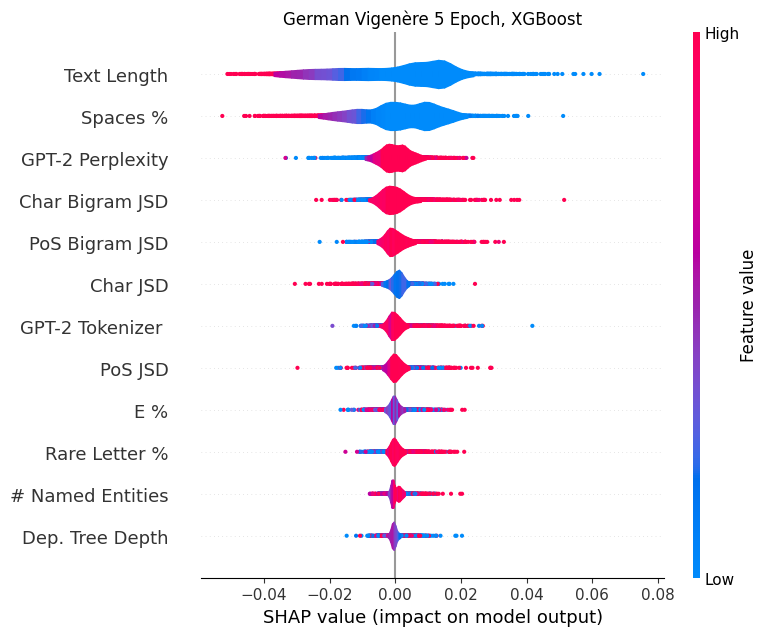

Processed de vignere 5 in 360.29142665863037 seconds
de vignere 10 mean MAE: 0.03888138618827316, R2: -9.847542710361701e-05
de vignere 10 ridge MAE: 0.03488538143915233, R2: 0.1835626848423677
de vignere 10 xgboost MAE: 0.03532189462549031, R2: 0.16292172605244382
de vignere 10 randomforest MAE: 0.03543610531673361, R2: 0.15854893734501263
de vignere 10 mlp MAE: 0.035597070484269876, R2: 0.14933573543117573


 99%|===================| 9941/10000 [00:52<00:00]        

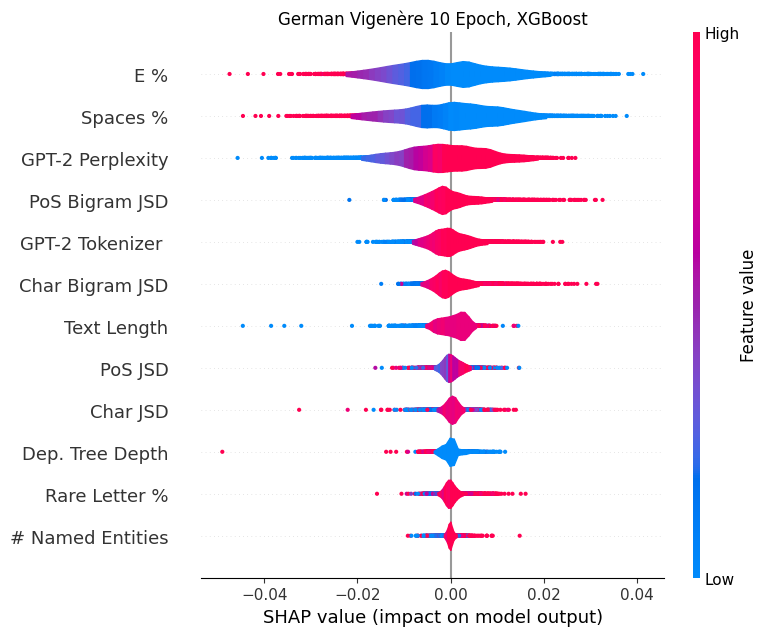

Processed de vignere 10 in 381.7606246471405 seconds
de vignere 15 mean MAE: 0.06716745929048158, R2: -0.00030194328789989733
de vignere 15 ridge MAE: 0.06205413394356661, R2: 0.16533293684332784
de vignere 15 xgboost MAE: 0.06197335755749536, R2: 0.16328388953757578
de vignere 15 randomforest MAE: 0.06201070704031854, R2: 0.16572715611161204
de vignere 15 mlp MAE: 0.062493205805474364, R2: 0.1660717345534184


 99%|===================| 9871/10000 [00:53<00:00]        

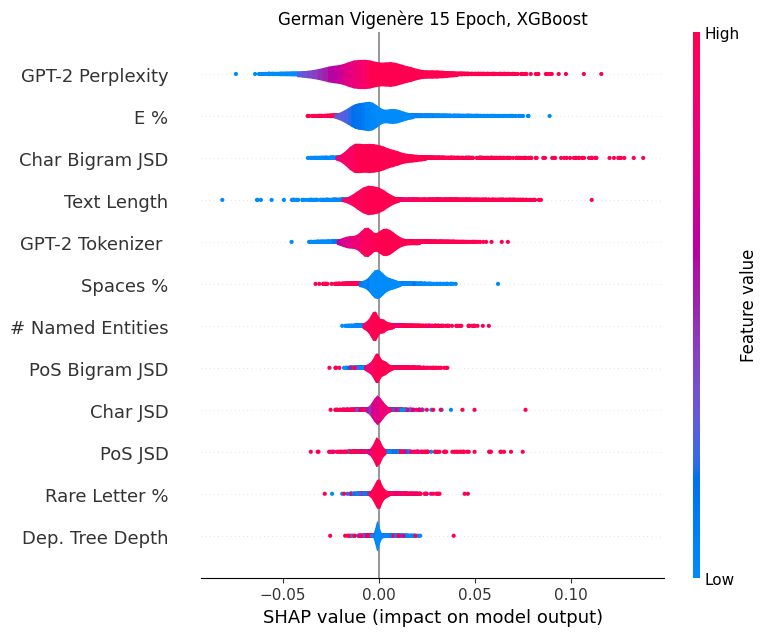

Processed de vignere 15 in 374.78044605255127 seconds
de vignere 20 mean MAE: 0.044030621226654194, R2: -5.2748508363453794e-05
de vignere 20 ridge MAE: 0.0414701258148188, R2: 0.12138898954507527
de vignere 20 xgboost MAE: 0.04115714385325823, R2: 0.12866860186980955
de vignere 20 randomforest MAE: 0.04128710550679427, R2: 0.13178821921493666
de vignere 20 mlp MAE: 0.04089641306099191, R2: 0.14333900207699346


 99%|===================| 9858/10000 [00:47<00:00]        

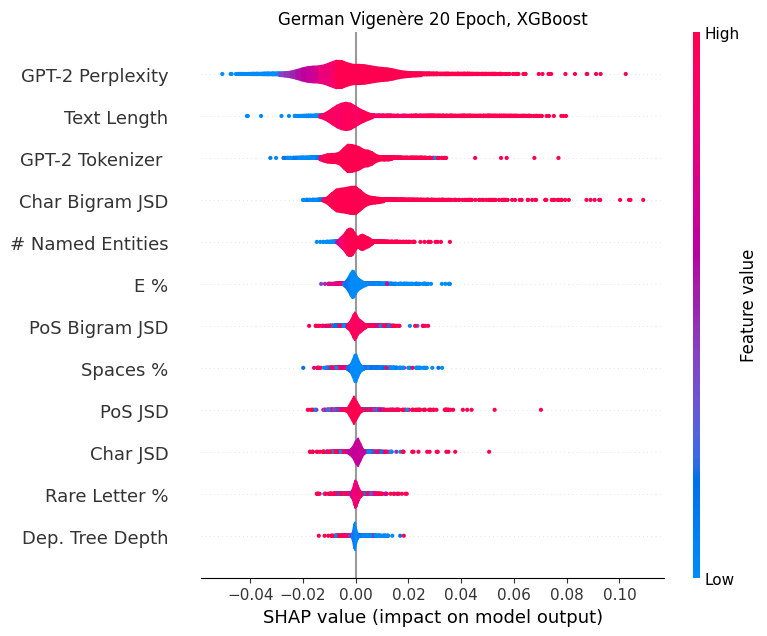

Processed de vignere 20 in 397.2790608406067 seconds
de vignere 25 mean MAE: 0.04005234340676411, R2: -9.243674732006824e-05
de vignere 25 ridge MAE: 0.03770371796781614, R2: 0.12172071361789438
de vignere 25 xgboost MAE: 0.03746794923254014, R2: 0.13131752431836463
de vignere 25 randomforest MAE: 0.037654577855985624, R2: 0.1299489149684533
de vignere 25 mlp MAE: 0.03700432128647152, R2: 0.12186500515667731


 99%|===================| 9860/10000 [00:50<00:00]        

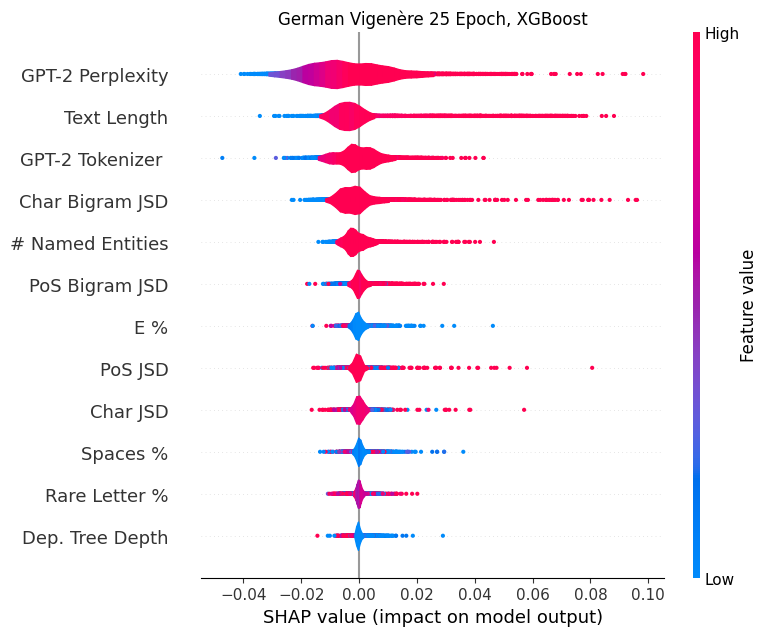

Processed de vignere 25 in 376.51901626586914 seconds
de vignere 30 mean MAE: 0.038550424772795994, R2: -0.0003514504954278408
de vignere 30 ridge MAE: 0.03621584413863238, R2: 0.12173658514556451
de vignere 30 xgboost MAE: 0.035766280807452554, R2: 0.1355690201417995
de vignere 30 randomforest MAE: 0.035877262562217765, R2: 0.13670269201941865
de vignere 30 mlp MAE: 0.03632241614509272, R2: 0.1415205870831202


100%|===================| 9992/10000 [00:46<00:00]        

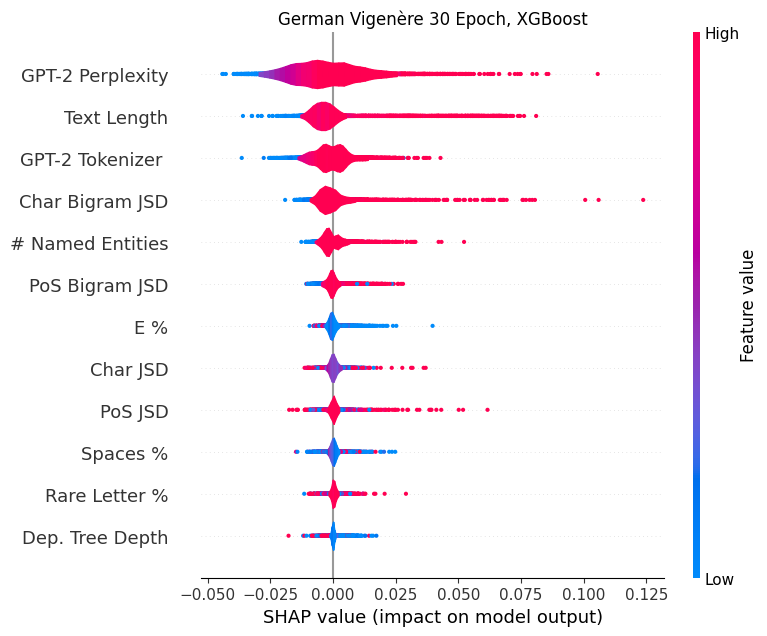

Processed de vignere 30 in 401.7053003311157 seconds
de vignere 35 mean MAE: 0.03813407300313037, R2: -5.117947859090144e-05
de vignere 35 ridge MAE: 0.0359076829716093, R2: 0.12439379819617413
de vignere 35 xgboost MAE: 0.035447631926583685, R2: 0.13509039049312954
de vignere 35 randomforest MAE: 0.03561389410284567, R2: 0.13736166667557448
de vignere 35 mlp MAE: 0.03553525844645859, R2: 0.14933598465295073


100%|===================| 9951/10000 [00:48<00:00]        

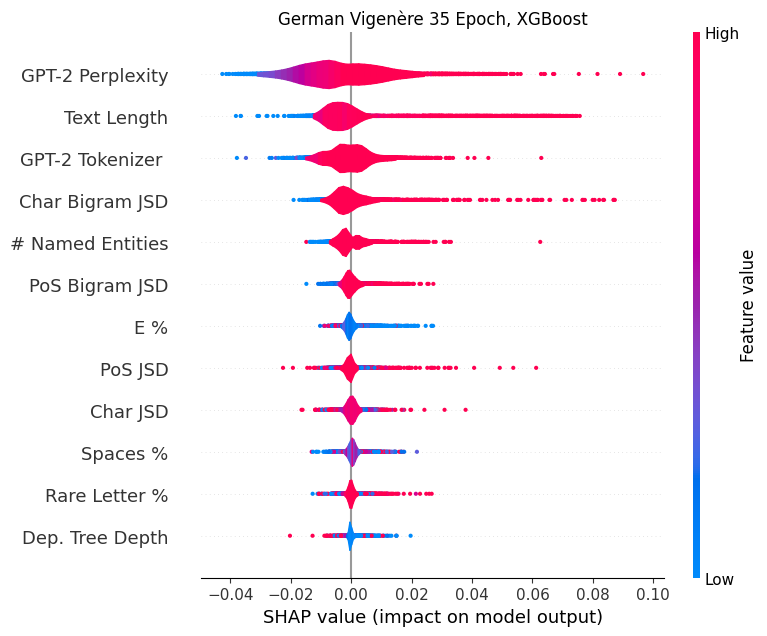

Processed de vignere 35 in 381.25244188308716 seconds
de vignere 40 mean MAE: 0.03765729450823027, R2: -7.597692472671724e-05
de vignere 40 ridge MAE: 0.03547652665944592, R2: 0.12951496933978046
de vignere 40 xgboost MAE: 0.03495015472657443, R2: 0.13724036645014515
de vignere 40 randomforest MAE: 0.03512186467024035, R2: 0.13937518896961
de vignere 40 mlp MAE: 0.03503938939752331, R2: 0.1523145952719469


 99%|===================| 9917/10000 [00:50<00:00]        

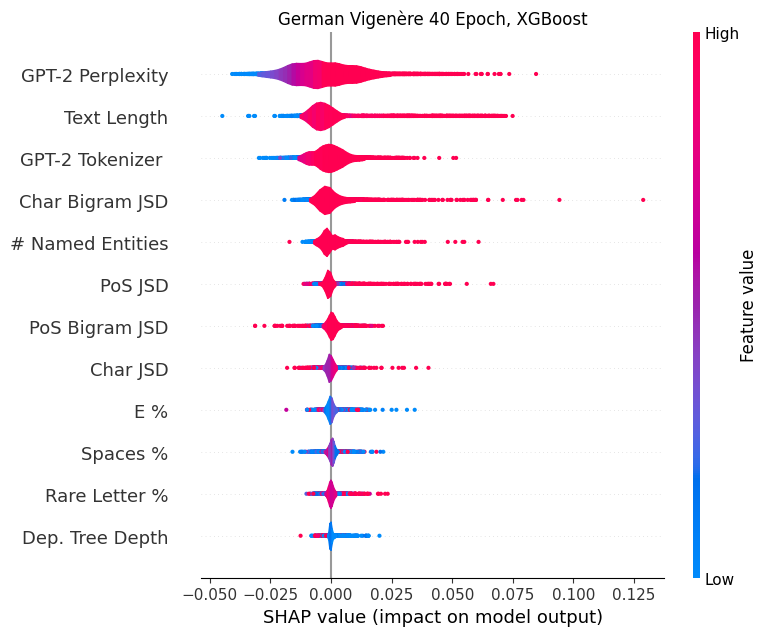

Processed de vignere 40 in 384.64716124534607 seconds


In [6]:
# from time import time
# for lang in langs:
#     for kind in ["enigma", "vignere"]:
#         for epoch in steps_epoch_mapping.keys():
#             t1 = time()
#             pred_eval_checkpoint(lang, kind, epoch, save_charts=True, save_num=True)
#             print(f"Processed {lang} {kind} {epoch} in {time()-t1} seconds")